In [12]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import igraph as ig
%matplotlib inline

from planar import create_proximity_graph
from auxiliary import get_base_network_name
import mpl_settings_v3
from mpl_settings_v3 import *
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cycler import cycler
from auxiliary import getLinearReg

net_type = 'DT'
param = 'param'

net_dir = os.path.join('../networks', net_type)
fig_dir = '../draft/figs'

attack_dict = {
    'Ran': r'$\mathrm{Rnd}$', 'Deg': r'$\mathrm{ID}$', 'DegU': r'$\mathrm{RD}$',
    'Btw': r'$\mathrm{IB}$', 'BtwU': r'$\mathrm{RB}$', 
    'Eigenvector': r'$\mathrm{IE}$', 'EigenvectorU': r'$\mathrm{RE}$',
    'CI': r'$\mathrm{ICI}$', 'CIU': r'$\mathrm{RCI}$', 'CIU2': r'$\mathrm{RCI2}$',
}

for i in range(2, 100):
    attack_dict['BtwU_cutoff{}'.format(i)] = r'$\mathrm{RB}$' + r'${{{}}}$'.format(i)

measures_dict = {
    'Nsec': r'$N_2$',
    'meanS': r'$\langle s \rangle$'
}

letters = [r'$\mathrm{(a)}$', r'$\mathrm{(b)}$', r'$\mathrm{(c)}$', r'$\mathrm{(d)}$',
           r'$\mathrm{(e)}$', r'$\mathrm{(f)}$', r'$\mathrm{(g)}$', r'$\mathrm{(h)}$']

attack_colors = {
    'B': '#27647b', 'D': '#ca3542', 'R': '#57575f', 'E': '#50C878',
    'C': '#80471C', # Brown peanut
    'B3': '#6F2DA8', # Purple
    'B4': '#F05E23' # Orange salamander
}

#attack_colors = {'B': '#27647b', 'D': '#ca3542', 'R': '#7b4609'}
#attack_colors = {'B': '#27647b', 'D': '#ca3542', 'R': '#c36e13'}

#c36e13 Orange
#7b4609 Brown
#57575f Grey
#attack_colors = {'B': colors[0], 'D': colors[1], 'R': '#57575f'}

In [2]:
def load_dataframe(attack, size, param, net_type='ER', fast=False, n_seeds=None):
    dir_name = os.path.join('../networks', net_type)
    base_net_name, base_net_name_size = get_base_network_name(net_type, size, param)
    if fast:
        base_csv_file_name = '{}_nSeeds{:d}_cpp.csv'.format(attack, n_seeds)
    else:
        base_csv_file_name = '{}_cpp.csv'.format(attack)
    csv_file_name = os.path.join(dir_name, base_net_name, base_net_name_size, base_csv_file_name)
    df = pd.read_csv(csv_file_name, index_col=0)
    return df

def load_dfs(attack, N_values, meank, net_type):

    dfs100 = {}
    dfs1000 = {}
    dfs10000 = {}
    dfs20000 = {}
    dfs50000 = {}
    for N in N_values:
        try:
            dfs100[N] = load_dataframe(attack, N, meank, net_type=net_type, fast=True, n_seeds=100)
        except:
            pass
        try:
            dfs1000[N] = load_dataframe(attack, N, meank, net_type=net_type, fast=True, n_seeds=1000)
        except:
            pass
        try:
            dfs10000[N] = load_dataframe(attack, N, meank, net_type=net_type, fast=True, n_seeds=10000)
        except:
            pass
        try:
            dfs20000[N] = load_dataframe(attack, N, meank, net_type=net_type, fast=True, n_seeds=20000)
        except:
            pass
        try:
            dfs50000[N] = load_dataframe(attack, N, meank, net_type=net_type, fast=True, n_seeds=50000)
        except:
            pass

    dfsMax = {}
    for N in N_values:
        
        if N in dfs50000:
            dfsMax[N] = dfs50000[N]
        elif N in dfs20000:
            dfsMax[N] = dfs20000[N]
        elif N in dfs10000:
            dfsMax[N] = dfs10000[N]
        elif N in dfs1000:
            dfsMax[N] = dfs1000[N]
        else:
            dfsMax[N] = dfs100[N]
            
    return dfs1000, dfs10000, dfs20000, dfsMax

def compute_fc_v2(dfs, min_f, max_f, method='beta', only_next=False, verbose=False):

    N_values = sorted(list(dfs.keys()))
    
    
    N1_over_N2 = {}
    for N in N_values:
        if method == 'beta':
            N1_over_N2[N] = ((N*dfs[N]['Sgcc'])/dfs[N]['Nsec']).values
        elif method == 'binder':
            N1_over_N2[N] = dfs[N]['meanS']/(N*(dfs[N]['Sgcc']**2)).values

    max_N = N_values[-1]
    mask = np.arange(int(min_f*max_N), int(max_f*max_N))
    n_values = len(mask)
    x = dfs[max_N]['f'][mask].values
    inter_values = []
    s = np.zeros(n_values)
    for i, Na in enumerate(N_values):
        for j, Nb in enumerate(N_values):
            if Nb <= Na:
                continue
            if only_next and j != i+1:
                continue
            mask = np.arange(int(min_f*Na), int(max_f*Na))
            xp = dfs[Na]['f'][mask].values
            fp = N1_over_N2[Na][mask]
            Na_values = np.interp(x, xp, fp)

            mask = np.arange(int(min_f*Nb), int(max_f*Nb))
            xp = dfs[Nb]['f'][mask].values
            fp = N1_over_N2[Nb][mask]
            Nb_values = np.interp(x, xp, fp)
            s += np.fabs(1 - Na_values/Nb_values)
            inter = np.argmin(s)/max_N
            if verbose:
                print(Na, Nb, inter+min_f, sep='\t')
            inter_values.append(inter)
    mean_inter = np.mean(inter_values)
    std_inter = np.std(inter_values)
    fc = min_f + mean_inter
    return fc, std_inter

def compute_crossings(dfs, min_f, max_f, method='beta', only_next=False, verbose=False):

    N_values = sorted(list(dfs.keys()))
        
    N1_over_N2 = {}
    for N in N_values:
        if method == 'beta':
            N1_over_N2[N] = ((N*dfs[N]['Sgcc'])/dfs[N]['Nsec']).values
        elif method == 'binder':
            N1_over_N2[N] = dfs[N]['meanS']/(N*(dfs[N]['Sgcc']**2)).values

    max_N = N_values[-1]
    mask = np.arange(int(min_f*max_N), int(max_f*max_N))
    n_values = len(mask)
    x = dfs[max_N]['f'][mask].values
    inter_values = []
    s = np.zeros(n_values)
    for i, Na in enumerate(N_values):
        for j, Nb in enumerate(N_values):
            if Nb <= Na:
                continue
            if only_next and j != i+1:
                continue
            mask = np.arange(int(min_f*Na), int(max_f*Na))
            xp = dfs[Na]['f'][mask].values
            fp = N1_over_N2[Na][mask]
            Na_values = np.interp(x, xp, fp)

            mask = np.arange(int(min_f*Nb), int(max_f*Nb))
            xp = dfs[Nb]['f'][mask].values
            fp = N1_over_N2[Nb][mask]
            Nb_values = np.interp(x, xp, fp)
            s += np.fabs(1 - Na_values/Nb_values)
            inter = np.argmin(s)/max_N
            inter_values.append([Na, Nb, inter+min_f])
            print(Na, Nb, inter+min_f, sep='\t')
            
    return inter_values

from sklearn.linear_model import LinearRegression

def getPeaks(dfs, measure):
    N_values = sorted(dfs.keys())
    
    fc_values  = []
    max_values = []
        
    for i, N in enumerate(N_values):
        df = dfs[N]
        max_idx = df[measure].idxmax()
        max_value = df[measure][max_idx]
            
        fc_values.append(max_idx/N)
        max_values.append(max_value)
        
    return fc_values, max_values

def get_critical_measures(dfs, measure, fc):
    
    N_values = sorted(dfs.keys())
    
    if fc == 'peak':
        fc_values, _ = getPeaks(dfs, measure)
    elif isinstance(fc, float): 
        fc_values = [fc] * len(N_values)
    else:
        print('ERROR')
        
    crit_values = []    
    for i, N in enumerate(N_values):
        df = dfs[N]
        fc = fc_values[i]
            
        if measure == 'Sgcc':
            crit_values.append(N*df[measure][int(fc*N)])
        else:
            crit_values.append(df[measure][int(fc*N)])
        
    return np.array(crit_values)  

def powerlaw(X, a, c):
    return c*np.array(X)**a

def getLinearReg(sizes, values, return_r2=False):

    X = np.log(sizes)
    Y = np.log(values)
    coeffs, cov = np.polyfit(X, Y, 1, cov=True)
    errors = np.sqrt(np.diag(cov))
    
    intercept = coeffs[1]
    slope = coeffs[0]
    y_error = 3*errors[0] ## Use three times standard error
    Y_pred = intercept + X*slope
    
    if return_r2:
        return np.exp(Y_pred), slope, linear_regressor.score(X, Y)
    return np.exp(Y_pred), slope, y_error

fontsize = 26

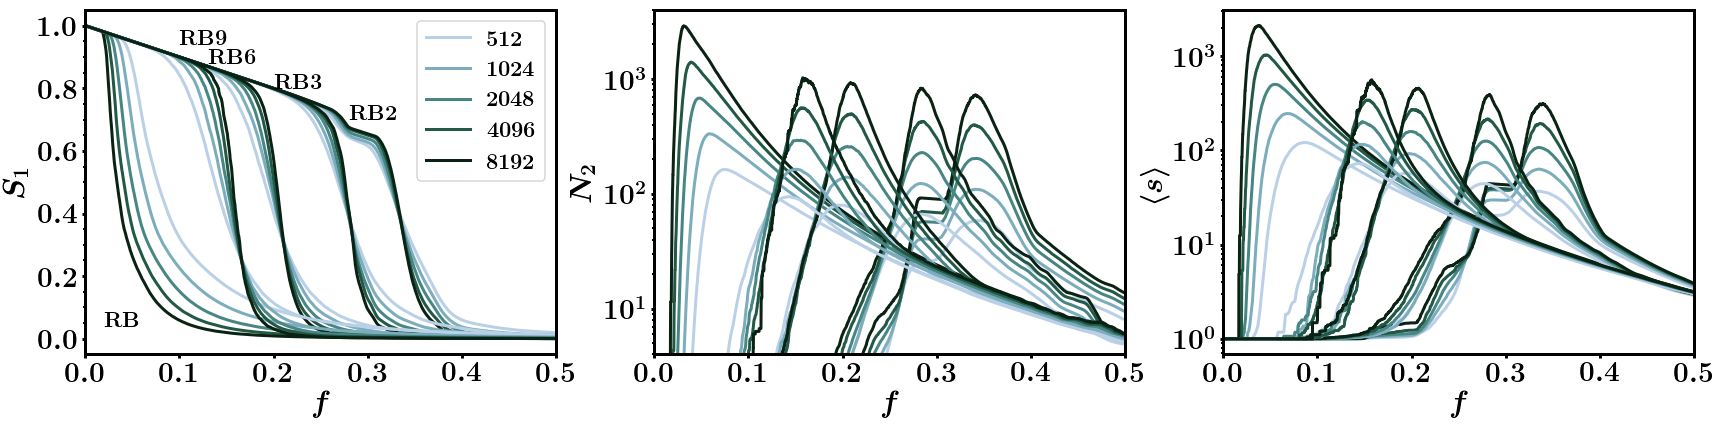

In [39]:
l_values = [2, 3, 6, 9]
attacks = ['BtwU'] + ['BtwU_cutoff{}'.format(i) for i in l_values]
N_values = [512, 1024, 2048, 4096, 8192]
colors = sns.cubehelix_palette(len(N_values), start=2, rot=0.3, 
                               light=0.8, dark=0.1)

text_pos = {
    'BtwU': (0.02, 0.04),
    'BtwU_cutoff2': (0.28, 0.7),
    'BtwU_cutoff3': (0.20, 0.8),
    'BtwU_cutoff6': (0.13, 0.88),
    'BtwU_cutoff9': (0.1, 0.94),
}

ncols = 3
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
for ax in axes.flatten():
    ax.set_xlabel(r'$f$')
    ax.set_xlim(0, 0.5)
    
ax = axes[0]
ax.set_ylabel(r'$S_1$')

ax = axes[1]
ax.set_ylabel(r'$N_2$')
ax.set_yscale('log')
ax.set_ylim((4, 4000))

ax = axes[2]
ax.set_ylabel(r'$\langle s \rangle$')
ax.set_yscale('log')

for j, attack in enumerate(attacks):
    x, y = text_pos[attack]
    axes[0].text(x, y, attack_dict[attack], fontsize=22)
    _, _, _, dfs = load_dfs(attack, N_values, param, net_type)
    for i, N in enumerate(N_values):
        if attack == 'BtwU':
            label = r'${{{}}}$'.format(N)
        else:
            label = ''
        df = dfs[N]
        axes[0].plot(df.f, df.Sgcc, '-', label=label, color=colors[i])
        axes[1].plot(df.f, df.Nsec, '-', color=colors[i])
        axes[2].plot(df.f, df.meanS, '-', color=colors[i])
        #axes[3].plot(df.f, np.abs(df.chiDelta), '-', color=colors[i])
        
axes[0].legend(loc='best', fontsize=22)
plt.tight_layout()    
fig_name = os.path.join(fig_dir, 'fig1_' + net_type)
plt.savefig(fig_name + '.png'.format(N))
plt.savefig(fig_name + '.pdf'.format(N))
plt.show()

DegU	0.38035 +- 0.00145
BtwU	0.00000 +- 0.00000
CIU	0.37905 +- 0.00134
BtwU_cutoff2	0.34085 +- 0.00328
BtwU_cutoff3	0.29363 +- 0.00304
BtwU_cutoff4	0.27048 +- 0.00367
BtwU_cutoff5	0.24266 +- 0.00118


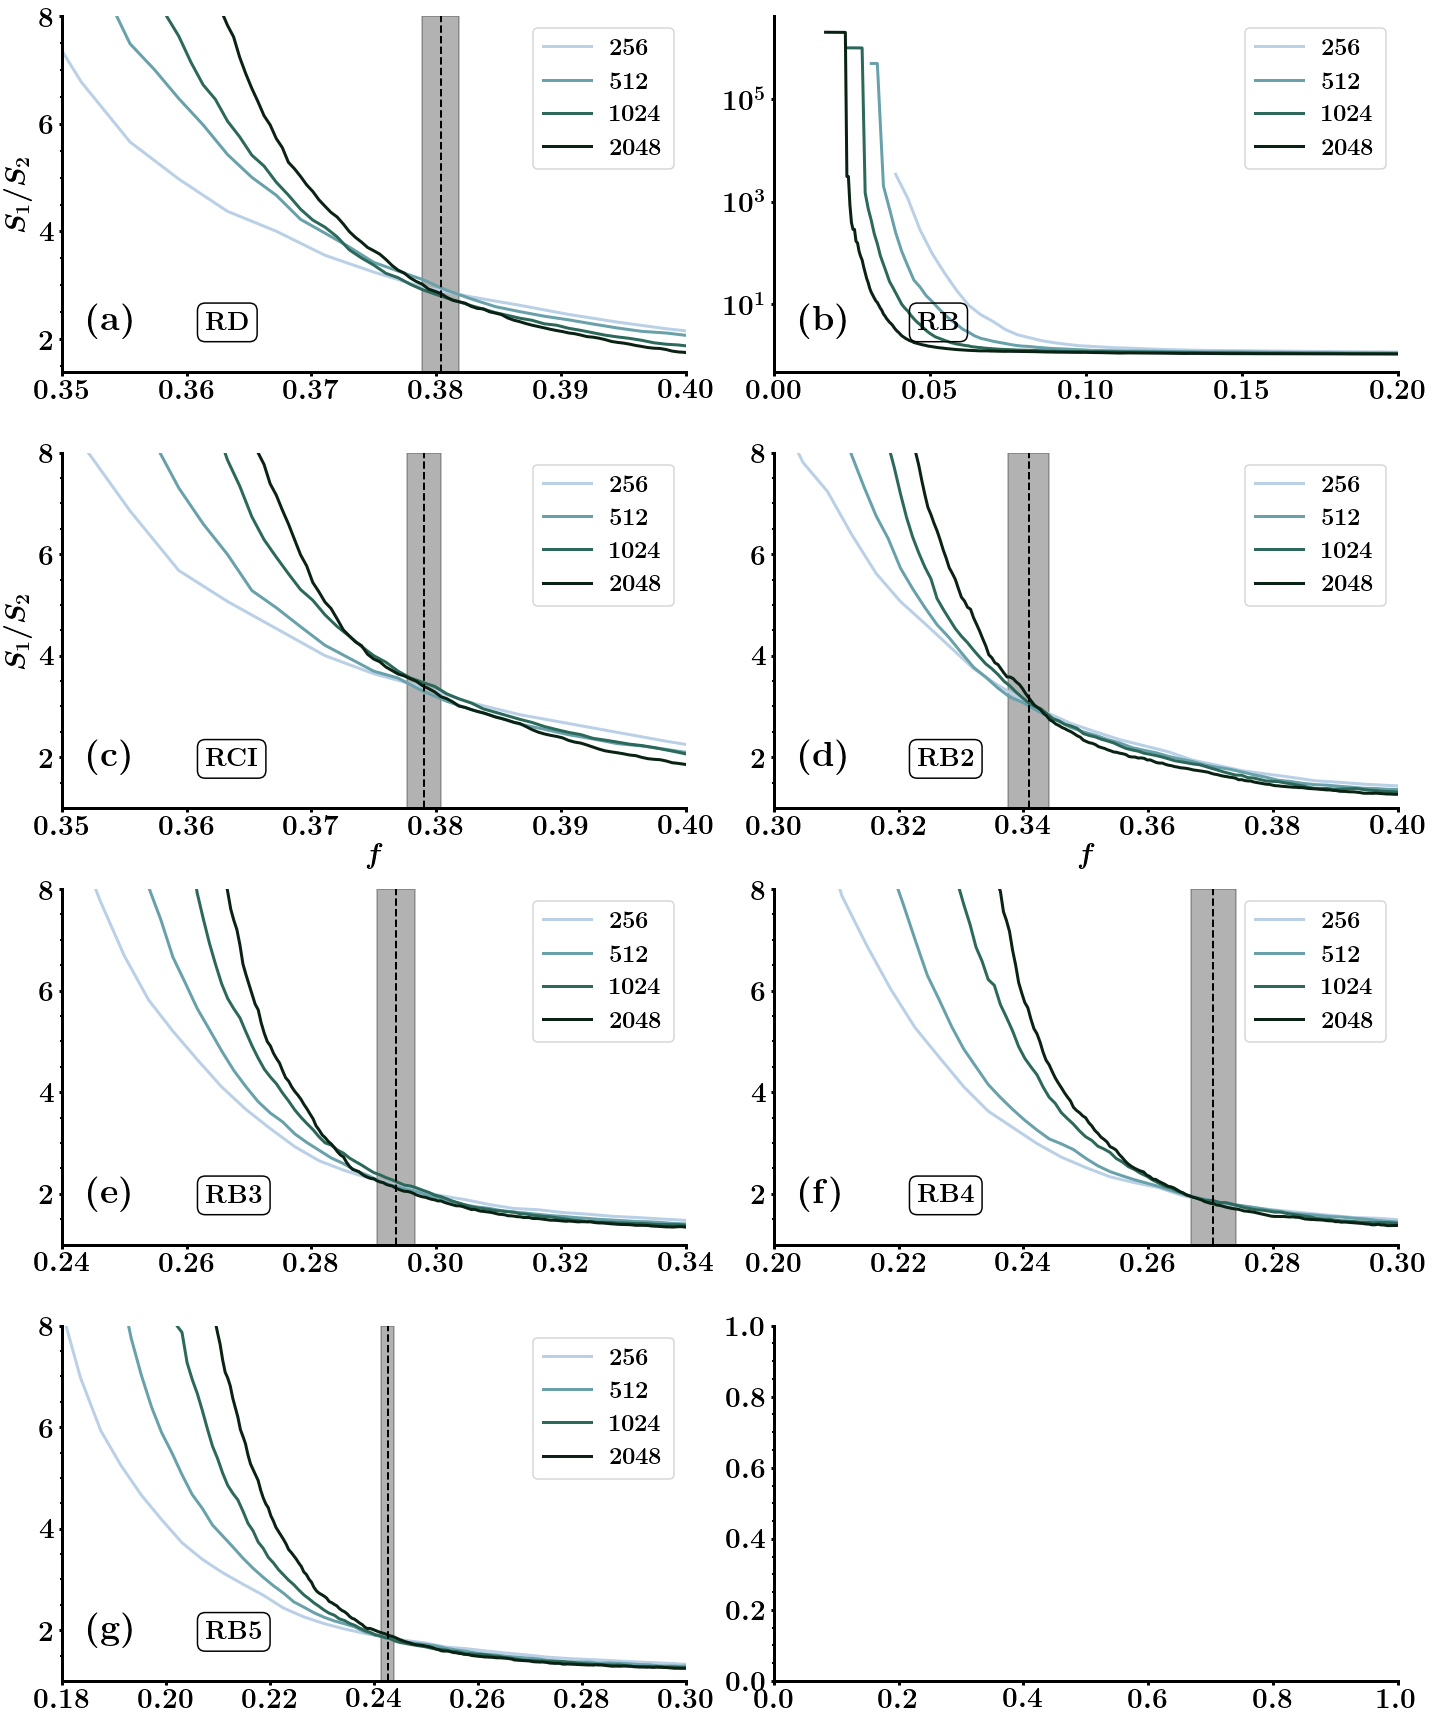

In [499]:
def plot_S1_over_S2(net_type):

    ncols = 2
    nrows = 4
    fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()

    attacks = ['DegU', 'BtwU', 'CIU', 'BtwU_cutoff2', 'BtwU_cutoff3', 'BtwU_cutoff4', 'BtwU_cutoff5']
    for j, attack in enumerate(attacks):

        N_values = [256, 512, 1024, 2048]    
        meank = 5
        _, _, _, dfs = load_dfs(attack, N_values, meank, net_type=net_type)
        
        ax = axes[j]
        if attack == 'Ran':
            fmin = 0.4
            fmax = 0.8
            ymin = 1.
            ymax = 5.       

        if attack == 'DegU':
            fmin = 0.35
            fmax = 0.4
            ymin = 1.4
            ymax = 8
            
        if attack == 'BtwU':
            fmin = 0.
            fmax = 0.2
            ymin = 1.
            ymax = 4.0
            
        if attack == 'BtwU_cutoff2':
            fmin = 0.3
            fmax = 0.4
            ymin = 1.
            ymax = 8.0
            
        if attack == 'BtwU_cutoff3':
            fmin = 0.24
            fmax = 0.34
            ymin = 1.
            ymax = 8.0
            
        if attack == 'BtwU_cutoff4':
            fmin = 0.2
            fmax = 0.3
            ymin = 1.
            ymax = 8.0
            
        if attack == 'BtwU_cutoff5':
            fmin = 0.18
            fmax = 0.3
            ymin = 1.
            ymax = 8.0
             
        if attack == 'CIU':
            fmin = 0.35
            fmax = 0.4
            ymin = 1.
            ymax = 8.0
            
        ax.set_xlim(fmin, fmax)
        if attack == 'BtwU':
            ax.set_yscale('log')
        else:
            ax.set_ylim(ymin, ymax)
            
        if j in [0, 2]:
            ax.set_ylabel(r'$S_1/S_2$', fontsize=28)
        if j in [2, 3]:
            ax.set_xlabel(r'$f$', fontsize=28)

        _N_values = list(dfs.keys())
        colors = sns.cubehelix_palette(len(_N_values), start=2, rot=0.3, 
                                       light=0.8, dark=0.1)
        for i, N in enumerate(_N_values):

            df = dfs[N]
            S1_over_S2 = N * df.Sgcc / df.Nsec
            ax.plot(df.f, S1_over_S2, '-', label=r'${{{}}}$'.format(N), color=colors[i])


        mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, only_next=False, verbose=False)
        print('{}\t{:.5f} +- {:.5f}'.format(attack, mean_fc, std_fc))
        
        ax.axvline(mean_fc, linestyle='--', color='k', linewidth=2)
        ax.fill_betweenx([ymin, ymax], mean_fc-std_fc, mean_fc+std_fc, color='k', alpha=0.3)
    
        bbox = {'boxstyle': 'round', 'fc': 'None'}
        #ax.text(0.1, 0.1, attack_dict[attack], fontsize=26, transform=ax.transAxes, bbox=bbox, 
        ax.text(0.23, 0.12, attack_dict[attack], fontsize=26, transform=ax.transAxes, bbox=bbox, 
                horizontalalignment='left')
        ax.text(0.04, 0.12, letters[j], fontsize=36, transform=ax.transAxes, 
                horizontalalignment='left')
        ax.legend(loc='best', fontsize=24)

    sns.despine()
    plt.tight_layout()

    fig_name = os.path.join(fig_dir, 'crossing_method_' + net_type)
    plt.savefig(fig_name + '.png'.format(N))
    plt.savefig(fig_name + '.pdf'.format(N))
    
    plt.show()
    
net_type = 'DT'
plot_S1_over_S2(net_type=net_type)

MR
CIU
CIU2
BtwU_cutoff2
BtwU_cutoff3
DT
CIU
CIU2
BtwU_cutoff2
BtwU_cutoff3


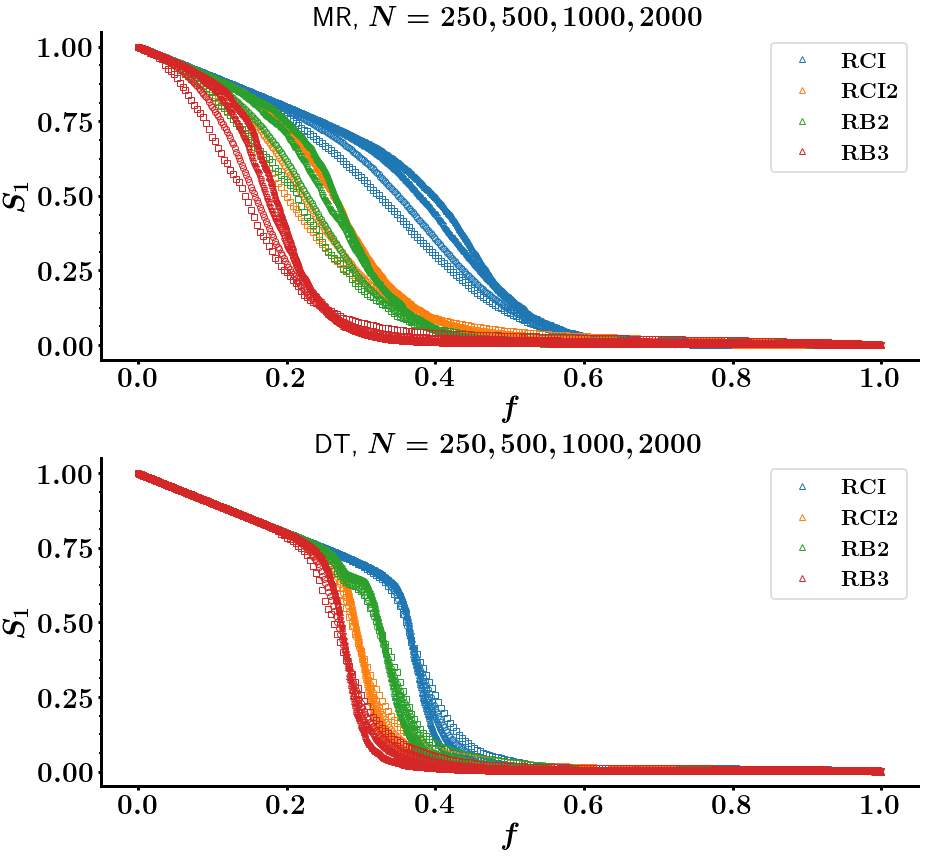

In [129]:
#attacks = ['Ran', 'DegU', 'BtwU']
attacks = ['CIU', 'CIU2', 'BtwU_cutoff2', 'BtwU_cutoff3']

N_values_per_attack = {
    'Ran': [250, 500, 1000, 2000, 16000],
    'DegU': [250, 500, 1000, 2000],
    'BtwU': [250, 500, 1000, 2000],
    'CIU': [250, 500, 1000, 2000],
    'CIU2': [250, 500, 1000, 2000],
    'BtwU_cutoff2': [250, 500, 1000, 2000],
    'BtwU_cutoff3': [250, 500, 1000, 2000]
}

ncols = 1
nrows = 2
fig, axes = plt.subplots(figsize=(13*ncols, 6*nrows), ncols=ncols, nrows=nrows)
for k, net_type in enumerate(['MR', 'DT']):
    print(net_type)
    ax = axes[k]
    ax.set_title(net_type + ', ' + r'$N = 250, 500, 1000, 2000$', fontsize=28)
    sns.despine()
    ax.set_ylabel(r'$S_1$')
    ax.set_xlabel(r'$f$')
    #ax.set_xlim(0, 1)
    #ax.set_ylim(-0.02, 1)
    for j, attack in enumerate(attacks):
        print(attack)
        N_values = N_values_per_attack[attack]
        _, _, _, dfs = load_dfs(attack, N_values, param, net_type=net_type)         

        for i, N in enumerate(N_values):

            X = np.arange(N) / N
            Y = dfs[N]['Sgcc'] 

            if i == len(N_values) - 1:
                label = attack_dict[attack]
            else:
                label = ''
            ax.plot(X, Y, label=label, marker=markers[i], color=colors[j], fillstyle='none', linestyle='')
        #ax.plot(X, 1 - X, color='k', linestyle='-.')

    ax.legend(loc='best', fontsize=22)
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'norrenbrock_fig1_2')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

DT
Ran
DegU
BtwU
BtwU_cutoff2
BtwU_cutoff3
BtwU_cutoff4
BtwU_cutoff5


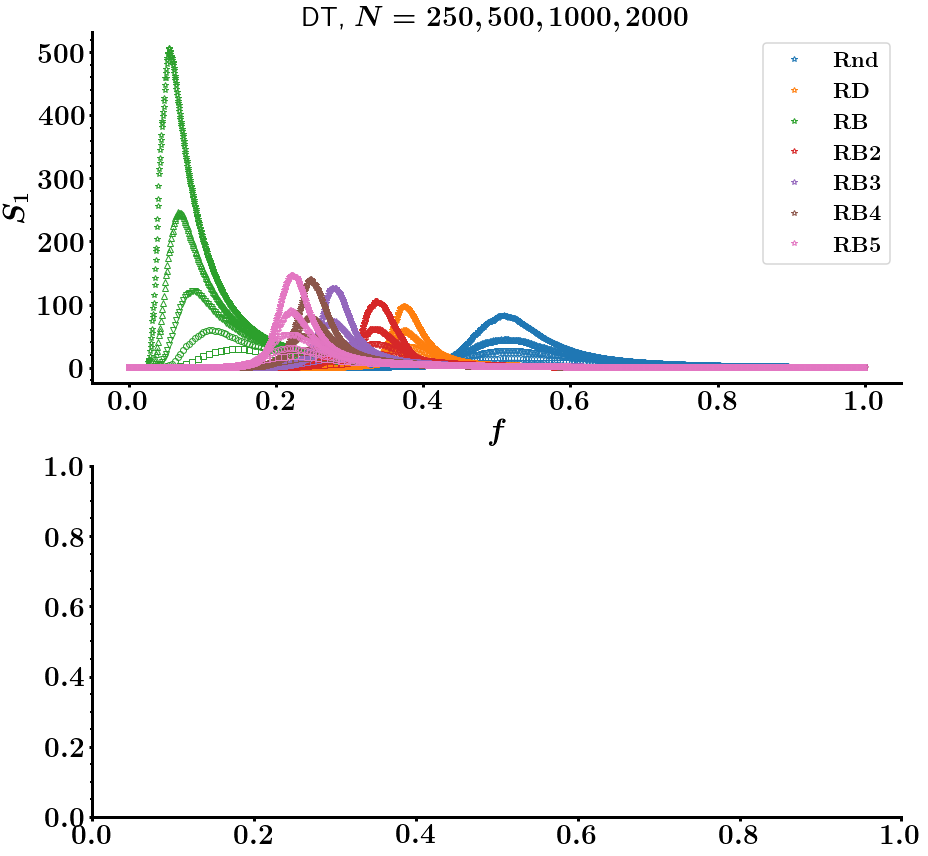

In [105]:
attacks = ['Ran', 'DegU', 'BtwU', 'BtwU_cutoff2', 'BtwU_cutoff3', 'BtwU_cutoff4', 'BtwU_cutoff5']
#attacks = ['CIU', 'CIU2', 'BtwU_cutoff2', 'BtwU_cutoff3']

_N_values = [128, 256, 512, 1024, 2048]
N_values_per_attack = {
    'Ran': _N_values,
    'DegU': _N_values,
    'BtwU': _N_values,
    'CIU': _N_values,
    'CIU2': _N_values,
    'BtwU_cutoff2': _N_values,
    'BtwU_cutoff3': _N_values,
    'BtwU_cutoff4': _N_values,
    'BtwU_cutoff5': _N_values
}

ncols = 1
nrows = 2
fig, axes = plt.subplots(figsize=(13*ncols, 6*nrows), ncols=ncols, nrows=nrows)
for k, net_type in enumerate(['DT']):
    print(net_type)
    ax = axes[k]
    ax.set_title(net_type + ', ' + r'$N = 250, 500, 1000, 2000$', fontsize=28)
    sns.despine()
    ax.set_ylabel(r'$S_1$')
    ax.set_xlabel(r'$f$')
    #ax.set_xlim(0, 1)
    #ax.set_ylim(-0.02, 1)
    for j, attack in enumerate(attacks):
        #print(attack)
        N_values = N_values_per_attack[attack]
        _, _, _, dfs = load_dfs(attack, N_values, param, net_type=net_type)         

        for i, N in enumerate(N_values):

            X = np.arange(N) / N
            Y = dfs[N]['meanS'] 

            if i == len(N_values) - 1:
                label = attack_dict[attack]
            else:
                label = ''
            ax.plot(X, Y, label=label, marker=markers[i], color=colors[j], fillstyle='none', linestyle='')
        #ax.plot(X, 1 - X, color='k', linestyle='-.')

    ax.legend(loc='best', fontsize=22)
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'meanS_2')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


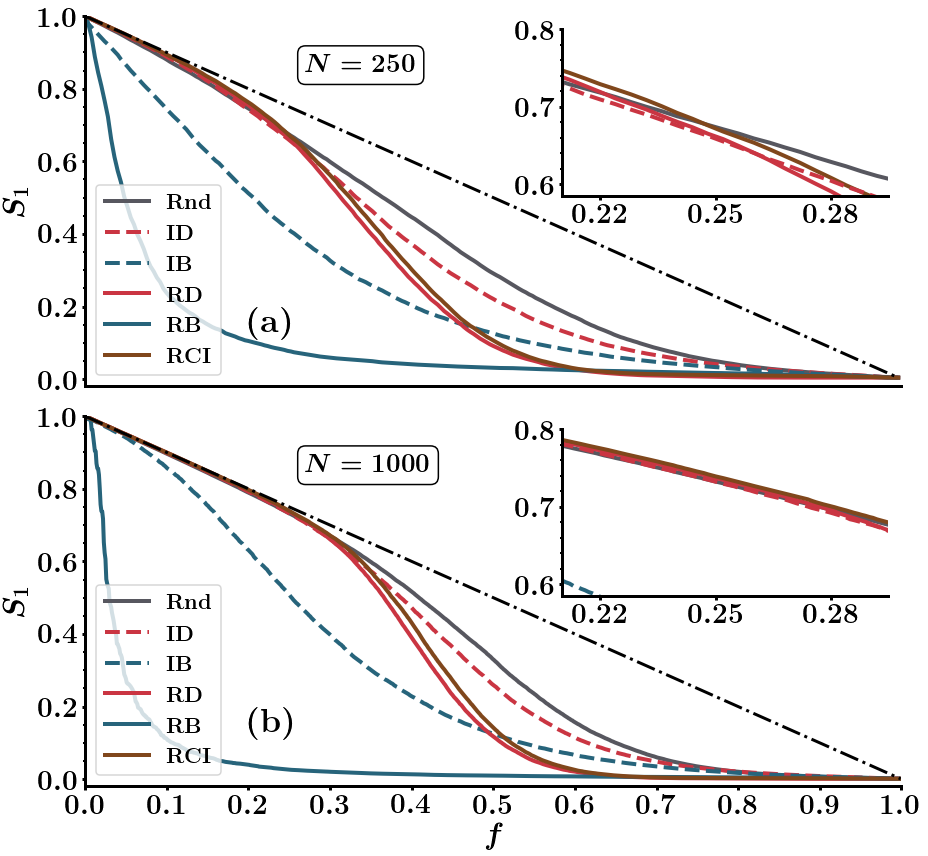

In [17]:
def plot_fig_order_param(dfs, N_values, inset=False):
    
    ncols = 1
    nrows = 2
    fig, axes = plt.subplots(figsize=(13*ncols, 6*nrows), ncols=ncols, nrows=nrows)

    for i, N in enumerate(N_values):
        ax = axes[i]
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel(r'$S_1$')
        if i == 1:
            ax.set_xlabel(r'$f$')
        X = np.arange(N) / N
        Y1 = dfs['BtwU'][N]['Sgcc'] 
        Y2 = dfs['DegU'][N]['Sgcc']
        Y4 = dfs['Btw'][N]['Sgcc'] 
        Y5 = dfs['Deg'][N]['Sgcc']
        Y3 = dfs['Ran'][N]['Sgcc']
        #Y6 = dfs['Eigenvector'][N]['Sgcc']
        #Y7 = dfs['EigenvectorU'][N]['Sgcc']
        #Y8 = dfs['CI'][N]['Sgcc']
        Y9 = dfs['CIU'][N]['Sgcc']
        #Y10 = dfs['BtwU_cutoff3'][N]['Sgcc']
        ax.set_xlim(0, 1)
        ax.set_ylim(-0.02, 1)
        if i == 1:
            ax.set_xticks(np.arange(0, 1.1, 0.1))
        else:
            ax.set_xticks([])
        ax.set_yticks(np.arange(0, 1.1, 0.2))
        ax.plot(X, Y3, label=r'$\mathrm{Rnd}$', color=attack_colors['R'], linewidth=4)
        ax.plot(X, Y5, label=r'$\mathrm{ID}$', color=attack_colors['D'], linewidth=4, linestyle='--')
        ax.plot(X, Y4, label=r'$\mathrm{IB}$', color=attack_colors['B'], linewidth=4, linestyle='--')
        #ax.plot(X, Y6, label=r'$\mathrm{IE}$', color=attack_colors['E'], linewidth=4, linestyle='--')
        #ax.plot(X, Y8, label=r'$\mathrm{RCI}$', color=attack_colors['C'], linewidth=4, linestyle='--')
        ax.plot(X, Y2, label=r'$\mathrm{RD}$', color=attack_colors['D'], linewidth=4)
        ax.plot(X, Y1, label=r'$\mathrm{RB}$', color=attack_colors['B'], linewidth=4)
        #ax.plot(X, Y7, label=r'$\mathrm{RE}$', color=attack_colors['E'], linewidth=4)
        ax.plot(X, Y9, label=r'$\mathrm{RCI}$', color=attack_colors['C'], linewidth=4)
        #ax.plot(X, Y10, label=r'$\mathrm{RB3}$', color=attack_colors['B3'], linewidth=4)
        ax.plot(X, 1 - X, color='k', linestyle='-.')

        bbox = {'boxstyle': 'round', 'fc': 'None'}
        if inset:
            ax.text(0.27, 0.85, r'$N = {{{:d}}}$'.format(N), fontsize=26, transform=ax.transAxes, bbox=bbox)
        else:
            ax.text(0.7, 0.45, r'$N\; = {{{:d}}}$'.format(N) + '\n' + r'$\langle k \rangle=4$', 
                    fontsize=26, transform=ax.transAxes, bbox=bbox)

            
        ax.text(0.2, 0.15, letters[i], fontsize=34, transform=ax.transAxes, 
                horizontalalignment='left')
        ax.legend(loc='lower left', fontsize=22)

        if inset:
            bbox_to_anchor = (.6, .55, .4, .45)
            axins = inset_axes(ax, width="100%", height="100%",
                    bbox_to_anchor=bbox_to_anchor,
                    bbox_transform=ax.transAxes)
            axins.spines['right'].set_visible(False)
            axins.spines['top'].set_visible(False)
            
            ## For meank = 4
            #axins.set_xlim(0.14, 0.217)
            #axins.set_ylim(0.585, 0.83)
            #axins.set_xticks([0.15, 0.18, 0.21])
            #axins.set_yticks([0.6, 0.7, 0.8])
            
            ## For meank = 5
            axins.set_xlim(0.21, 0.295)
            axins.set_ylim(0.585, 0.77)
            axins.set_xticks([0.22, 0.25, 0.28])
            axins.set_yticks([0.6, 0.7, 0.8])
            axins.plot(X, Y3, color=attack_colors['R'], linewidth=4)
            axins.plot(X, Y2, color=attack_colors['D'], linewidth=4)
            axins.plot(X, Y1, color=attack_colors['B'], linewidth=4)
            #axins.plot(X, Y7, color=attack_colors['E'], linewidth=4)
            axins.plot(X, Y9, color=attack_colors['C'], linewidth=4)
            axins.plot(X, Y5, color=attack_colors['D'], linewidth=4, linestyle='--')
            axins.plot(X, Y4, color=attack_colors['B'], linewidth=4, linestyle='--')
            #axins.plot(X, Y6, color=attack_colors['E'], linewidth=4, linestyle='--')
            #axins.plot(X, Y8, color=attack_colors['C'], linewidth=4, linestyle='--')
    plt.tight_layout()
    fig_name = os.path.join(fig_dir, 'percolation_two_sizes')
    plt.savefig(fig_name + '.png'.format(N))
    plt.savefig(fig_name + '.pdf'.format(N))
    plt.show()
    
meank = 5
N_values = [250, 1000]
dfs = {}
attacks = ['Ran', 'Deg', 'DegU', 'Btw', 'BtwU', 'CIU']
for attack in attacks:
    
    _, _, _, _dfs = load_dfs(attack, N_values, meank, net_type='MR')    
    dfs[attack] = _dfs
plot_fig_order_param(dfs, N_values, inset=True)

Ran
Deg
DegU
BtwU
CIU
CIU2
BtwU_cutoff2
BtwU_cutoff3
BtwU_cutoff4


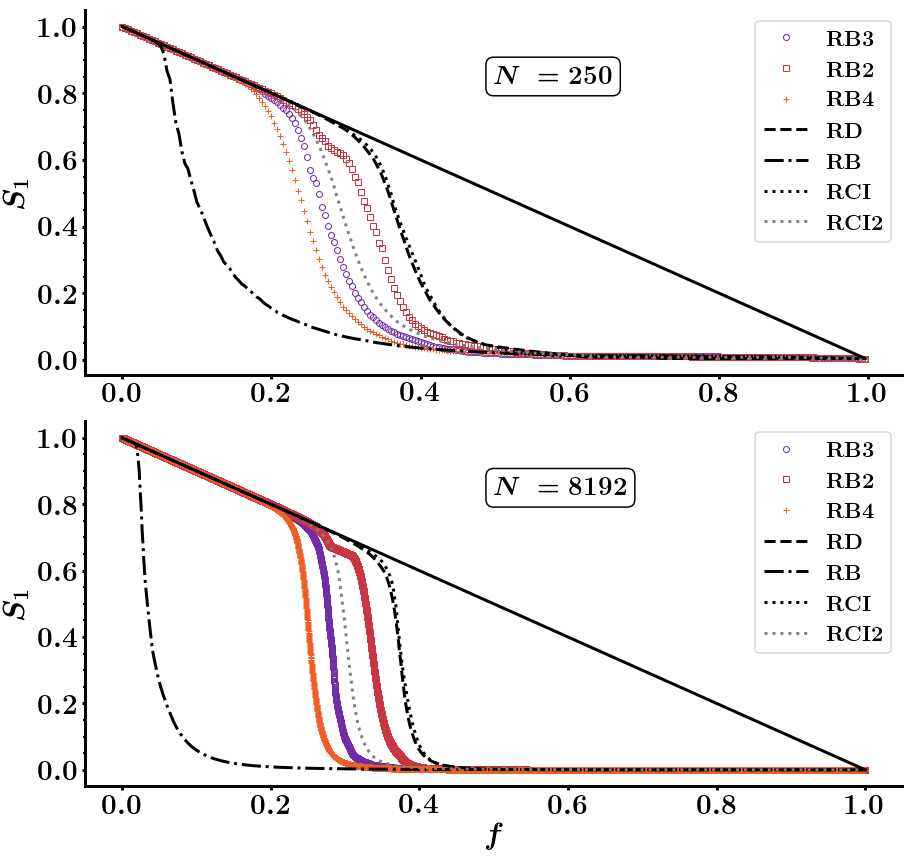

In [44]:
def plot_fig_order_param(dfs, N_values, net_type):

    ncols = 1
    nrows = 2
    fig, axes = plt.subplots(figsize=(13*ncols, 6*nrows), ncols=ncols, nrows=nrows)

    for i, N in enumerate(N_values):
        ax = axes[i]
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel(r'$S_1$')
        if i == 1:
            ax.set_xlabel(r'$f$')
        X = np.arange(N) / N
        if 'BtwU' in dfs:
            Y1 = dfs['BtwU'][N]['Sgcc'] 
        Y2 = dfs['DegU'][N]['Sgcc']
        #Y4 = dfs['Btw'][N]['Sgcc'] 
        Y5 = dfs['Deg'][N]['Sgcc']
        Y3 = dfs['Ran'][N]['Sgcc']
        #Y6 = dfs['Eigenvector'][N]['Sgcc']
        #Y7 = dfs['EigenvectorU'][N]['Sgcc']
        #Y8 = dfs['CI'][N]['Sgcc']
        Y9 = dfs['CIU'][N]['Sgcc']
        Y13 = dfs['CIU2'][N]['Sgcc']
        Y10 = dfs['BtwU_cutoff3'][N]['Sgcc']
        Y11 = dfs['BtwU_cutoff2'][N]['Sgcc']
        Y12 = dfs['BtwU_cutoff4'][N]['Sgcc']
        #ax.set_xlim(0.25, 0.36)
        #ax.set_ylim(-0.02, 0.82)
        #if i == 1:
        #    ax.set_xticks(np.arange(0.2, 0.4, 0.05))
        #else:
        #    ax.set_xticks([])
        #ax.set_yticks(np.arange(0, 1.1, 0.2))
        ax.set_prop_cycle(marker=['o', 's', '+', 'x', '^', '*', '.'])
        #ax.plot(X, Y3, '.', label=r'$\mathrm{Rnd}$', color=attack_colors['R'], linewidth=4)
        #ax.plot(X, Y2, label=r'$\mathrm{RD}$', color=attack_colors['D'], linestyle='', fillstyle='none')
        
        #ax.plot(X, Y1, label=r'$\mathrm{RB}$', color=attack_colors['B'], linestyle='', fillstyle='none')
        
        #ax.plot(X, Y7, label=r'$\mathrm{RE}$', color=attack_colors['E'], linestyle='', fillstyle='none')
        
        ax.plot(X, Y10, label=r'$\mathrm{RB3}$', color=attack_colors['B3'], linestyle='', fillstyle='none')
        ax.plot(X, Y11, label=r'$\mathrm{RB2}$', color=attack_colors['D'], linestyle='', fillstyle='none')
        ax.plot(X, Y12, label=r'$\mathrm{RB4}$', color=attack_colors['B4'], linestyle='', fillstyle='none')
        
        ax.plot(X, Y2, label=r'$\mathrm{RD}$', color='k', linestyle='--', marker='', linewidth=3)
        if 'BtwU' in dfs:
            ax.plot(X, Y1, label=r'$\mathrm{RB}$', color='k', linestyle='-.', marker='', linewidth=3)
        ax.plot(X, Y9, label=r'$\mathrm{RCI}$', color='k', linestyle=':', marker='', linewidth=3)
        ax.plot(X, Y13, label=r'$\mathrm{RCI2}$', color='grey', linestyle=':', marker='', linewidth=3)
        ax.plot(X, 1 - X, color='k', linestyle='-', marker='')

        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(0.5, 0.8, r'$N\; = {{{:d}}}$'.format(N), 
                    fontsize=26, transform=ax.transAxes, bbox=bbox)

            
        #ax.text(0.2, 0.25, letters[i], fontsize=34, transform=ax.transAxes, 
        #        horizontalalignment='left')
        ax.legend(loc='best', fontsize=22)

    plt.tight_layout()
    fig_name = os.path.join(fig_dir, 'percolation_two_sizes_new_{}'.format(net_type))
    plt.savefig(fig_name + '.png'.format(N))
    plt.savefig(fig_name + '.pdf'.format(N))
    plt.show()
    
meank = 5
N_values = [250, 8192]
dfs = {}
attacks = [
    'Ran', 'Deg', 'DegU', #'Btw', 
    'BtwU', 'CIU', 'CIU2',
    'BtwU_cutoff2', 'BtwU_cutoff3', 'BtwU_cutoff4'
]
net_type = 'DT'
for attack in attacks:
    print(attack)
    _, _, _, _dfs = load_dfs(attack, N_values, meank, net_type=net_type)    
    dfs[attack] = _dfs
plot_fig_order_param(dfs, N_values, net_type)

In [159]:
def plot_fig_order_param(dfs, N_values, inset=False):

    ncols = 1
    nrows = 2
    fig, axes = plt.subplots(figsize=(13*ncols, 6*nrows), ncols=ncols, nrows=nrows)

    for i, N in enumerate(N_values):
        ax = axes[i]
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel(r'$\langle s \rangle$')
        if i == 1:
            ax.set_xlabel(r'$f$')
        X = np.arange(N) / N
        measure = 'meanS'
        if 'BtwU' in dfs:
            Y1 = dfs['BtwU'][N][measure] 
        Y2 = dfs['DegU'][N][measure]
        Y4 = dfs['Btw'][N][measure] 
        Y5 = dfs['Deg'][N][measure]
        Y3 = dfs['Ran'][N][measure]
        #Y6 = dfs['Eigenvector'][N]['Sgcc']
        #Y7 = dfs['EigenvectorU'][N]['Sgcc']
        #Y8 = dfs['CI'][N]['Sgcc']
        Y9 = dfs['CIU'][N][measure]
        Y13 = dfs['CIU2'][N][measure]
        Y10 = dfs['BtwU_cutoff3'][N][measure]
        Y11 = dfs['BtwU_cutoff2'][N][measure]
        Y12 = dfs['BtwU_cutoff4'][N][measure]
        #ax.set_xlim(0.25, 0.36)
        #ax.set_ylim(-0.02, 0.82)
        #if i == 1:
        #    ax.set_xticks(np.arange(0.2, 0.4, 0.05))
        #else:
        #    ax.set_xticks([])
        #ax.set_yticks(np.arange(0, 1.1, 0.2))
        ax.set_prop_cycle(marker=['o', 's', '+', 'x', '^', '*', '.'])
        #ax.plot(X, Y3, '.', label=r'$\mathrm{Rnd}$', color=attack_colors['R'], linewidth=4)
        #ax.plot(X, Y2, label=r'$\mathrm{RD}$', color=attack_colors['D'], linestyle='', fillstyle='none')
        
        #ax.plot(X, Y1, label=r'$\mathrm{RB}$', color=attack_colors['B'], linestyle='', fillstyle='none')
        
        #ax.plot(X, Y7, label=r'$\mathrm{RE}$', color=attack_colors['E'], linestyle='', fillstyle='none')
        
        ax.plot(X, Y10, label=r'$\mathrm{RB3}$', color=attack_colors['B3'], linestyle='', fillstyle='none')
        ax.plot(X, Y11, label=r'$\mathrm{RB2}$', color=attack_colors['D'], linestyle='', fillstyle='none')
        ax.plot(X, Y12, label=r'$\mathrm{RB4}$', color=attack_colors['B4'], linestyle='', fillstyle='none')
        
        ax.plot(X, Y2, label=r'$\mathrm{RD}$', color='k', linestyle='--', marker='', linewidth=3)
        if 'BtwU' in dfs:
            ax.plot(X, Y1, label=r'$\mathrm{RB}$', color='k', linestyle='-.', marker='', linewidth=3)
        ax.plot(X, Y9, label=r'$\mathrm{RCI}$', color='k', linestyle=':', marker='', linewidth=3)
        ax.plot(X, Y13, label=r'$\mathrm{RCI2}$', color='grey', linestyle=':', marker='', linewidth=3)
        ax.plot(X, 1 - X, color='k', linestyle='-', marker='')

        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(0.5, 0.8, r'$N\; = {{{:d}}}$'.format(N), 
                    fontsize=26, transform=ax.transAxes, bbox=bbox)

            
        #ax.text(0.2, 0.25, letters[i], fontsize=34, transform=ax.transAxes, 
        #        horizontalalignment='left')
        ax.legend(loc='best', fontsize=22)

    plt.tight_layout()
    fig_name = os.path.join(fig_dir, 'meanS_two_sizes_new_{}'.format(net_type))
    plt.savefig(fig_name + '.png'.format(N))
    plt.savefig(fig_name + '.pdf'.format(N))
    plt.show()
    
meank = 5
N_values = [250, 4096]
dfs = {}
attacks = [
    'Ran', 'Deg', 'DegU', 'Btw', 'BtwU', 'CIU', 'CIU2',
    'BtwU_cutoff2', 'BtwU_cutoff3', 'BtwU_cutoff4'
]
net_type = 'MR'
for attack in attacks:
    print(attack)
    _, _, _, _dfs = load_dfs(attack, N_values, meank, net_type=net_type)    
    dfs[attack] = _dfs
plot_fig_order_param(dfs, N_values, net_type)

Ran


KeyError: 4096

In [27]:
attacks = [
    #'Ran', 'DegU', 
    'BtwU', 'BtwU_cutoff2', 'BtwU_cutoff3','BtwU_cutoff4', #'BtwU_cutoff6', 'BtwU_cutoff7', 
    'BtwU_cutoff8', #'BtwU_cutoff9',
    'BtwU_cutoff15'
]

In [21]:
all_comp_sizes_dict = {}
comp_dist_log = {}
for attack in attacks:
    comp_dist_log[attack] = {}
    all_comp_sizes_dict[attack] = {}

In [22]:
N_per_attack = {
    'Deg':  64000,
    'DegU': 2048,
    'Btw':  64000,
    'BtwU': 8192,
    'BtwU_cutoff2': 8192,
    'BtwU_cutoff3': 8192,
    'BtwU_cutoff4': 8192,
    'BtwU_cutoff6': 8192,
    'BtwU_cutoff7': 8192,
    'BtwU_cutoff8': 8192,
    'BtwU_cutoff9': 8192,
    'BtwU_cutoff15': 8192,
    'Ran': 2048
}
#for attack in attacks:
for attack in attacks:
    N = N_per_attack[attack]
    all_comp_sizes_dict[attack][N] = {}   
    comp_dist_log[attack][N] = {}

In [28]:
overwrite = False
all_f_values = {
    #'BtwU': ['0.0435'] # N = 4096
    #'BtwU': ['0.04500', '0.04736', '0.05000', '0.05469'], # N = 2048
    #'BtwU': ['0.02500', '0.03000', '0.03500', '0.03750', '0.04000', '0.04350', '0.05000'], # N = 4096
    'BtwU': [ '0.03000', '0.03250', '0.03500', '0.03750', '0.04000', '0.04250'],#, '0.05000'], # N = 4096
    'DegU': ['0.37354'], # N = 2048
    'Ran': ['0.50977'], # N = 2048
    'BtwU_cutoff2': ['0.30000', '0.31000', '0.32000', '0.33000', '0.34000'], # N = 8192
    'BtwU_cutoff3': ['0.26000', '0.27000', '0.28000', '0.29000', '0.30000'], # N = 8192
    'BtwU_cutoff4': ['0.23000', '0.24000', '0.25000', '0.26000', '0.27000'], # N = 8192
    'BtwU_cutoff6': ['0.18000', '0.19000', '0.20000', '0.21000', '0.22000'], # N = 8192
    'BtwU_cutoff7': ['0.18000', '0.19000', '0.20000', '0.21000'], # N = 8192
    'BtwU_cutoff8': ['0.16000', '0.17000', '0.18000', '0.19000', '0.20000'], # N = 8192
    'BtwU_cutoff9': ['0.15000', '0.16000', '0.17000', '0.18000'], # N = 8192
    'BtwU_cutoff15': ['0.09000', '0.09500', '0.10000', '0.11000'] # N = 8192
}

for attack in attacks:
    print(attack)
    
    gcc = False
    if attack in ['BtwU']:
        gcc = True
    
    N = N_per_attack[attack]
    f_values = all_f_values[attack]
    
    net_dir_name = '../networks/DT/DT_param'.format(param)
    base_net_name = 'DT_param_N{}'.format(N)
    base_net_dir_name = os.path.join(net_dir_name, base_net_name)

    for f_value in f_values:
        print(f_value)
        if f_value in all_comp_sizes_dict[attack][N]:
            continue
        if gcc:
            comp_sizes_file = 'comp_sizes_gcc_{}_f{}.txt'.format(attack, f_value)
        else:
            comp_sizes_file = 'comp_sizes_{}_f{}.txt'.format(attack, f_value)
        full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
        comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
        
        all_comp_sizes_dict[attack][N][f_value] = comp_sizes

BtwU
0.03000
0.03250
0.03500
0.03750
0.04000
0.04250
BtwU_cutoff2
0.30000
0.31000
0.32000
0.33000
0.34000
BtwU_cutoff3
0.26000
0.27000
0.28000
0.29000
0.30000
BtwU_cutoff4
0.23000
0.24000
0.25000
0.26000
0.27000
BtwU_cutoff8
0.16000
0.17000
0.18000
0.19000
0.20000
BtwU_cutoff15
0.09000
0.09500
0.10000
0.11000


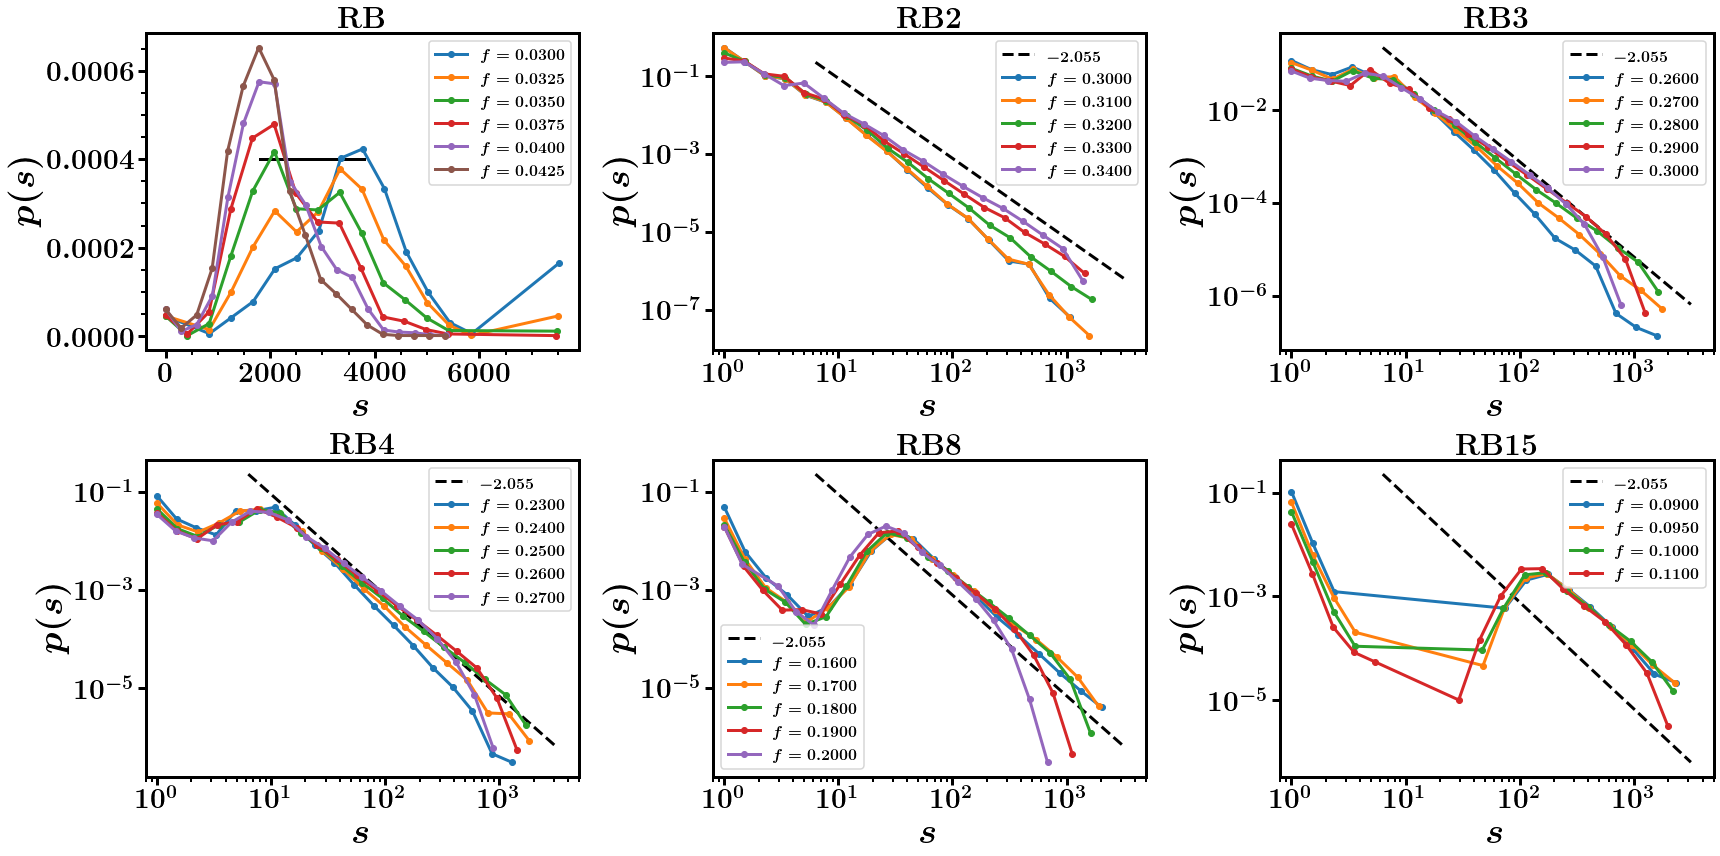

In [30]:
def get_histo(comp_sizes, log=True):
    mask = comp_sizes > 0
    comp_sizes = comp_sizes[mask]     
    min_s = np.min(comp_sizes)
    max_s = np.max(comp_sizes)
    if log:
        bins = np.logspace(np.log10(min_s), np.log10(max_s), 20)
    else:
        bins = np.linspace(min_s, max_s+1, 20)
    hist = np.histogram(comp_sizes, bins=bins, density=True)
    hist_norm = hist[0]
    hist_norm[hist_norm==0] = np.NaN
    mask = ~np.isnan(hist_norm)
    X = bins[:-1]
    X = X[mask]
    Y = hist_norm[mask]

    return X, Y

def plot_comp_sizes(attack, comp_sizes, f_values, ax, log=True):
    for i, f_value in enumerate(f_values):
        X, Y = get_histo(comp_sizes[f_value], log=log)

        label = r'$f={{{:.4f}}}$'.format(float(f_value))
        ax.plot(X, Y, '-' , marker='o', label=label)

    return
            
ylim = (1E-6, 7)
xlim = (0.8, 5000)
ncols = 3
nrows = len(attacks) // ncols + len(attacks) % ncols
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
axes = axes.flatten()
for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlim(xlim)
    #ax.set_ylim(ylim)
    ax.set_xlabel(r'$s$', fontsize=36)
    ax.set_ylabel(r'$p(s)$', fontsize=36)    

for i, attack in enumerate(attacks):
    ax = axes[i]
    ax.set_title(attack_dict[attack], fontsize=30)
    N = N_per_attack[attack]
    f_values = all_f_values[attack]
    log = True
    if attack == 'BtwU':
        log = False
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        
        ax.plot([1800, 3800], [0.0004]*2, color='k')
        ax.autoscale()
        ax.margins(0.05)
    elif 'cutoff' not in attack:
        X = np.logspace(0, 2.5)
        a = -2.055
        #c = Y[0] / X[0]**a
        c = 1
        Y = powerlaw(X, a, c)
        ax.plot(X, Y, '--', color='k', label=r'${{{:.3f}}}$'.format(a))
        
        a = -1.7
        #c = Y[0] / X[0]**a
        c = 1
        Y = powerlaw(X, a, c)
        ax.plot(X, Y, '-.', color='k', label=r'${{{:.3f}}}$'.format(a))
    else:
        X = np.logspace(0.8, 3.5)
        a = -2.055
        #c = Y[0] / X[0]**a
        c = 10
        Y = powerlaw(X, a, c)
        ax.plot(X, Y, '--', color='k', label=r'${{{:.3f}}}$'.format(a))
    plot_comp_sizes(attack, all_comp_sizes_dict[attack][N], f_values, ax, log=log)
    ax.legend(fontsize=16)
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'comp_sizes_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  """Entry point for launching an IPython kernel.


attack	      beta/(d*nu)  beta  gamma/(d*nu)   gamma     1  delta_1     tau delta_tau
Ran       	0.0547    0.1459    0.8343    2.2249    0.9437   0.1967  2.0615    1.0549
BtwU      	-0.0368    -0.0983    1.0288    2.7434    0.9551   0.0911  1.9629    -0.6029
BtwU_cutoff2	0.0828    0.2209    0.7768    2.0715    0.9425   0.1645  2.0963    0.7598
BtwU_cutoff3	0.1052    0.2807    0.7722    2.0592    0.9827   0.1717  2.1199    0.6399
BtwU_cutoff6	0.1095    0.2919    0.7526    2.0069    0.9715   0.1069  2.1270    0.3660
BtwU_cutoff7	0.1230    0.3280    0.7460    1.9894    0.9921   0.0515  2.1416    0.1415
BtwU_cutoff8	0.1090    0.2906    0.7749    2.0663    0.9929   0.1814  2.1233    0.5447
BtwU_cutoff10	0.1472    0.3924    0.7335    1.9560    1.0278   0.0738  2.1671    0.1883


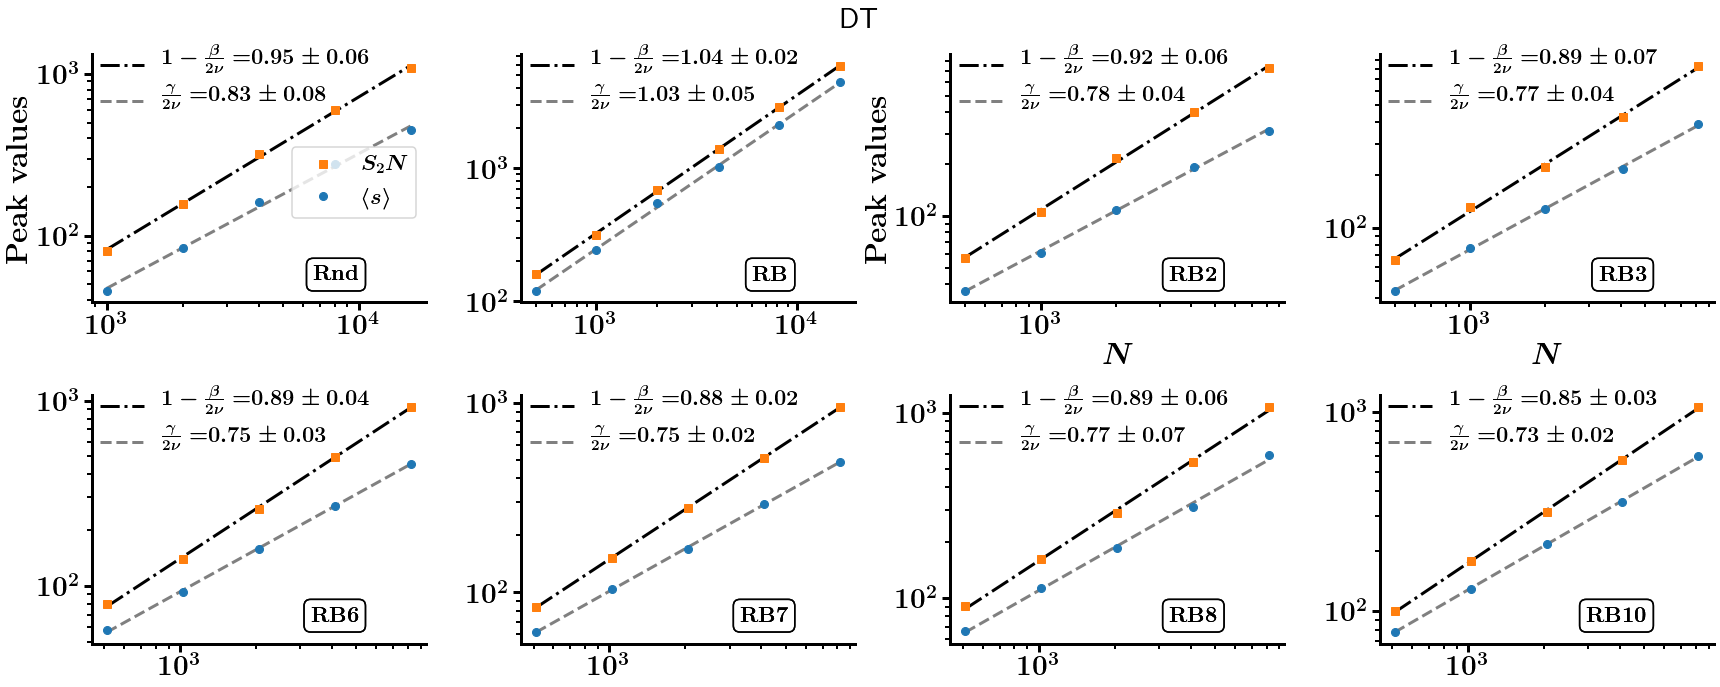

In [25]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
colors = mpl_settings_v3.colors

meank = 5
net_type = 'DT'
measures = ['Nsec', 'meanS']
attacks = ['Ran', #'Deg', 
           #'DegU', #'Btw', 
           'BtwU', 'BtwU_cutoff2', 'BtwU_cutoff3', #'BtwU_cutoff4', 
           'BtwU_cutoff6', #'BtwU_cutoff6', 
           'BtwU_cutoff7', 'BtwU_cutoff8', 'BtwU_cutoff10', 
           #'CIU',
           #'CIU2'
          ]#, 'Eigenvector', 'EigenvectorU', 'CIU']
marker_dict = {'meanS': 'o', 'Nsec': 's'}
color_dict = {'meanS': colors[0], 'Nsec': colors[1]}
linestyle_dict = {'meanS': '--', 'Nsec': '-.'}
label_dict = {'meanS': r'$\langle s \rangle$', 'Nsec': r'$S_2 N$'}

print('attack\t      beta/(d*nu)  beta  gamma/(d*nu)   gamma     1  delta_1     tau delta_tau')

ncols = 4
nrows = len(attacks) // ncols + len(attacks) % ncols
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
axes = axes.flatten()
fig.suptitle(net_type, fontsize=30)
for k, attack in enumerate(attacks):
    ax = axes[k]
    
    if attack == 'Ran':
        N_values = [1000, 2000, 4000, 8000, 16000]
        ylim = (9, 1200)
    if attack == 'Deg':
        N_values = [1000, 2000, 4000, 8000, 16000]
        ylim = (9, 1200)
    elif attack == 'DegU':
        N_values = [1000, 2000, 4000, 8000, 16000]
        ylim = (9, 1800)
    elif attack == 'Btw':
        N_values = [125, 250, 500, 1000, 2000]
        ylim = (9, 1200)
    elif attack == 'BtwU':
        N_values = [500, 1000, 2000, 4096, 8192, 16384]
    elif attack == 'BtwU_cutoff2':
        N_values = [500, 1000, 2000, 4096, 8192]
    elif attack == 'BtwU_cutoff3':
        N_values = [500, 1000, 2000, 4096, 8192]
    elif attack == 'BtwU_cutoff4':
        N_values = [500, 1000, 2000, 4096, 8192]
    elif attack == 'BtwU_cutoff5':
        N_values = [512, 1024, 2048, 4096, 8192]
    elif attack == 'BtwU_cutoff6':
        N_values = [512, 1024, 2048, 4096,8192]
    elif attack == 'BtwU_cutoff7':
        N_values = [512, 1024, 2048, 4096,8192]
    elif attack == 'BtwU_cutoff8':
        N_values = [512, 1024, 2048, 4096,8192]
    elif attack == 'BtwU_cutoff9':
        N_values = [512, 1024, 2048, 4096,8192]
    elif attack == 'BtwU_cutoff10':
        N_values = [512, 1024, 2048, 4096,8192]
        ylim = (50, 1600)
    elif attack == 'Eigenvector':
        N_values = [250, 500, 1000, 2000, 4000]
        ylim = (5, 600)
    elif attack == 'EigenvectorU':
        N_values = [250, 500, 1000, 2000]
        ylim = (10, 600)
    elif attack == 'CIU':
        N_values = [250, 500, 1000, 2000, 4000]
        ylim = (10, 600)
    elif attack == 'CIU2':
        N_values = [125, 250, 500, 1000, 2000]
        ylim = (10, 600)
    #ax.set_ylim(ylim)
            
    #N_values = [128, 256, 512, 1024, 2048]
    #N_values = [125, 250, 500, 1000, 2000, 4000]
    
    dfs1000, dfs10000, dfs20000, dfsMax = load_dfs(attack, N_values, meank, net_type=net_type)
    dfs = {}
    _N_values = N_values
    for N in _N_values:
        dfs[N] = dfsMax[N]
    N_values = list(dfs.keys())

    for i, measure in enumerate(measures):
        
        ax.tick_params(which='minor', length=5)
        ax.tick_params(which='major', length=8)
    
        measure_values = get_critical_measures(dfs, measure, fc='peak')
        Y_pred, slope, y_err = getLinearReg(N_values, measure_values)
        if measure == 'Nsec':
            beta_over_dnu = 1 - slope
            delta_beta = y_err
        elif measure == 'meanS':
            gamma_over_dnu = slope
            delta_gamma = y_err

        if k in [0, 2]:
            ax.set_ylabel(r'$\mathrm{Peak\;values}$')
        if k in [2, 3]:
            ax.set_xlabel(r'$N$')

        if measure == 'meanS':
            label = r'$\frac{\gamma}{2\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
            label1 = label
            line1, = ax.plot(N_values, Y_pred, '--', color='grey', label=label)
            
        elif measure == 'Nsec':
            #label = r'$\dfrac{\gamma}{\bar{\nu}} = {{{:.4f}}}\pm{{{:.4f}}}$'.format(slope, y_err)
            label = r'$1 - \frac{\beta}{2\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
            label2 = label
            line2, = ax.plot(N_values, Y_pred, '-.', color='k', label=label)            

        ax.set_xscale('log')
        ax.set_yscale('log')
        if k == 0:
            markers1, = ax.plot(N_values, measure_values, marker_dict[measure], 
                                color=color_dict[measure], markersize=8, label=label_dict[measure])
        else:
            markers2, = ax.plot(N_values, measure_values, marker_dict[measure],
                                color=color_dict[measure], markersize=8)
        
        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(0.8, 0.09, attack_dict[attack], fontsize=22, 
                transform=ax.transAxes, horizontalalignment='right', bbox=bbox)
    
    err_one = 2*delta_beta + delta_gamma
    tau = 2+beta_over_dnu/(beta_over_dnu+gamma_over_dnu)
    delta_tau = np.fabs(delta_beta)/beta_over_dnu +\
               (np.fabs(delta_gamma)+np.fabs(delta_beta))*(beta_over_dnu/(beta_over_dnu + gamma_over_dnu))
    print('{:10}\t{:.4f}    {:.4f}    {:.4f}    {:.4f}    {:.4f}   {:.4f}  {:.4f}    {:.4f}'.format(
        attack, beta_over_dnu, beta_over_dnu*(8/3), gamma_over_dnu, gamma_over_dnu*(8/3),
        2*beta_over_dnu+gamma_over_dnu, err_one, tau, delta_tau)
         )
    
        
    if k == 0:
        handles, labels = ax.get_legend_handles_labels()
        order = [1, 3]
        legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
                  fontsize=22, loc=(0.6, 0.34))
        ax.add_artist(legend1)
        order = [0, 2]
        ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
                  fontsize=22, loc=(0.0, 0.73), frameon=False)

    else:
        ax.legend(fontsize=22, loc=(0.0, 0.73), frameon=False)

sns.despine()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig_name = os.path.join(fig_dir, 'peak_scaling_' + net_type)
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

Deg	0.4653 2.80 0.08
DegU	0.3401 3.38 0.21
Btw	0.5573 3.52 0.16
BtwU	0.2974 2.66 0.23


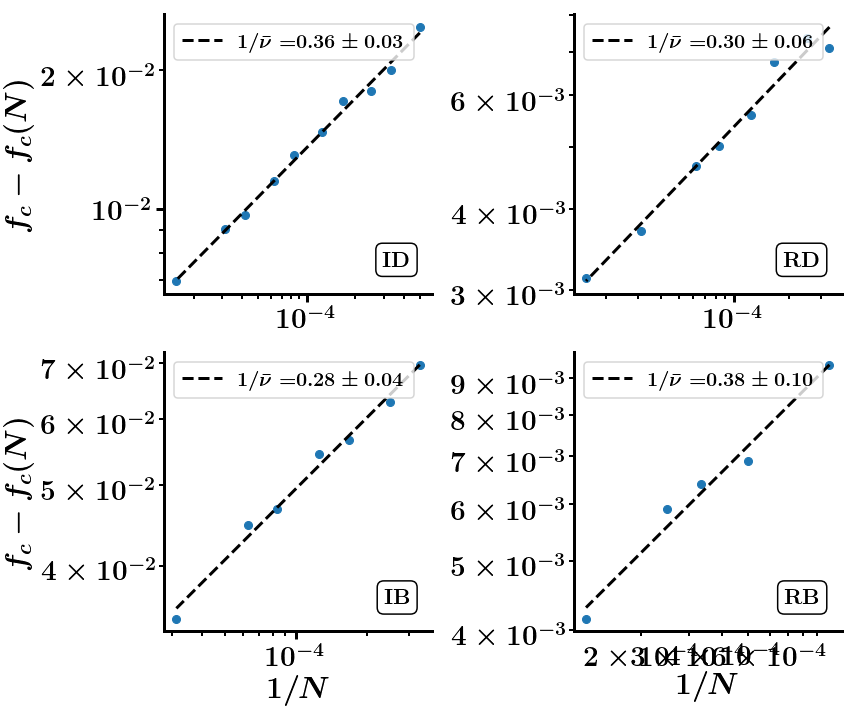

Deg	0.4653 3.19 0.12
DegU	0.3401 3.51 0.24
Btw	0.5573 3.55 0.12
BtwU	0.2974 3.06 0.38


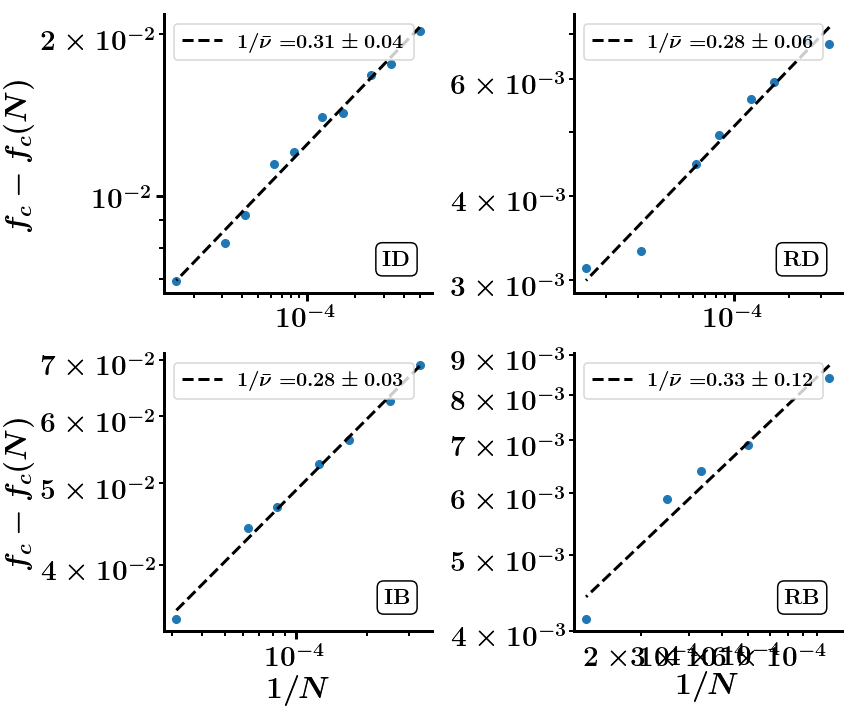

In [301]:
def plot_nu(measure):

    attacks = ['Deg', 'DegU', 'Btw', 'BtwU']
    marker_dict = {'meanS': 'o', 'Nsec': 's'}
    color_dict = {'meanS': colors[0], 'Nsec': colors[1]}
    linestyle_dict = {'meanS': '--', 'Nsec': '-.'}
    label_dict = {'meanS': r'$\langle s \rangle$', 'Nsec': r'$N_2$'}

    ncols = 2
    nrows = 2
    fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()

    for k, attack in enumerate(attacks):

        if attack == 'Deg':
            #N_values = [8000, 12000, 16000, 32000, 64000]
            N_values = [2000, 3000, 4000, 6000, 8000, 12000, 16000, 24000, 32000, 64000]
            fc_theo = 0.4653
            fmin = 0.44
            fmax = 0.49
        elif attack == 'DegU':
            N_values = [3000, 4000, 6000, 8000, 12000, 16000, 32000, 64000]
            fc_theo = 0.3401
            fmin = 0.334
            fmax = 0.345
        elif attack == 'Btw':
            N_values = [3000, 4000, 6000, 8000, 12000, 16000, 32000]
            fc_theo = 0.5573
            tolerance = fc_theo/500
            fmin = 0.5
            fmax = 0.6
        elif attack == 'BtwU':
            N_values = [1000, 2000, 3000, 4000, 8000]
            fc_theo = 0.2974
            tolerance = fc_theo/500
            fmin = 0.28
            fmax = 0.32

        dfs1000, dfs10000, dfs20000, dfsMax = load_dfs(attack, N_values, meank)
        dfs = {}
        _N_values = N_values
        for N in _N_values:
            dfs[N] = dfsMax[N]
        N_values = list(dfs.keys())
        
        #fc = compute_fc_v2(dfs, fmin, fmax)[0]
        #if attack == 'Deg' or attack == 'Btw':
        #    fc = fc_theo
        fc = fc_theo
                
        ax = axes[k]
        ax.tick_params(which='minor', length=5)
        ax.tick_params(which='major', length=8)
        
        
        measure_values = get_critical_measures(dfs, measure, fc='peak')
        Y_pred, slope, y_err = getLinearReg(N_values, measure_values)
        if measure == 'Nsec':
            beta_over_nu = 1 - slope
        elif measure == 'meanS':
            gamma_over_nu = slope

        if k in [0, 2]:
            #ax.set_ylabel(r'$N_2\; \mathrm{ and }\; \langle s \rangle$')
            ax.set_ylabel(r'$f_c - f_c(N)$')
        if k in [2, 3]:
            ax.set_xlabel(r'$1/N$')


        ax.set_xscale('log')
        ax.set_yscale('log')

        fc_values, peak_values = getPeaks(dfs, measure)
        fc_diff = fc - np.array(fc_values)
        one_over_N_values = 1/np.array(N_values)
        ax.plot(one_over_N_values, fc_diff, 'o', markersize=8)
        Y_pred, slope, y_err = getLinearReg(one_over_N_values, fc_diff)

        label = r'$1/\bar{\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
        ax.plot(one_over_N_values, Y_pred, '--', color='k', label=label)

        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(0.92, 0.1, attack_dict[attack], fontsize=22, 
                transform=ax.transAxes, horizontalalignment='right', bbox=bbox)

        ax.legend(fontsize=20, loc=2)
        
        #fc_16k = dict(zip(N_values, fc_values))[16000]
        #print('{}\t{:.4f} {:.2f} {:.2f} fc(16000) = {:.4f}'.format(attack, fc, 1/slope, y_err/(3*slope**2), fc_16k))
        print('{}\t{:.4f} {:.2f} {:.2f}'.format(attack, fc, 1/slope, y_err/(3*slope**2)))
        
        ax.set_xticks([1e-4])
        
    sns.despine()
    plt.tight_layout()

    fig_name = os.path.join(fig_dir, 'nu_' + measure)
    plt.savefig(fig_name + '.png')
    plt.savefig(fig_name + '.pdf')

    plt.show()
    
measures = ['meanS', 'Nsec']
for measure in measures:
    plot_nu(measure)

In [15]:
attacks = ['BtwU_cutoff{}'.format(i) for i in range(11, 12)]
for k, attack in enumerate(attacks):

    if attack == 'Ran':
        N_values = [1024, 2048, 4000, 8000, 16000]
    if attack == 'Deg':
        N_values = [1024, 2048, 4000, 8000, 16000]
    elif attack == 'DegU':
        N_values = [1024, 2048, 4000, 8000, 16000]
    elif attack == 'BtwU':
        N_values = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
    elif attack == 'BtwU_cutoff2':
        N_values = [128, 256, 512, 1024, 2048, 4096, 8192]
    elif attack == 'BtwU_cutoff3':
        N_values = [128, 256, 512, 1024, 2048, 4096, 8192]
    elif attack == 'BtwU_cutoff4':
        N_values = [128, 256, 512, 1024, 2048, 4096, 8192]
    elif attack == 'BtwU_cutoff5':
        N_values = [128, 256, 512, 1024, 2048, 4096, 8192]
    elif attack == 'BtwU_cutoff6':
        N_values = [128, 256, 512, 1024, 2048, 8192]
    elif attack == 'BtwU_cutoff7':
        N_values = [128, 256, 512, 1024, 2048, 8192]
    elif attack == 'BtwU_cutoff8':
        N_values = [128, 256, 512, 1024, 2048, 8192]
    elif attack == 'BtwU_cutoff9':
        N_values = [128, 256, 512, 1024, 2048, 8192]
    elif attack == 'BtwU_cutoff10':
        N_values = [128, 256, 512, 1024, 2048, 8192]
    elif attack in ['BtwU_cutoff{}'.format(i) for i in range(11, 16)]:
        N_values = [8192]

    dfs1000, dfs10000, dfs20000, dfsMax = load_dfs(attack, N_values, param, net_type)
    dfs = {}
    _N_values = N_values
    for N in _N_values:
        dfs[N] = dfsMax[N]
    N_values = list(dfs.keys())
    measures = ['meanS', 'Nsec']
    for measure in measures:
        fc_values, peak_values = getPeaks(dfs, measure)
        if measure == 'meanS':
            print(attack, N_values, fc_values)

BtwU_cutoff11 [8192] [0.134033203125]


BtwU [128, 256, 512, 1024, 2048, 4096, 8192, 16384] [0.1484375, 0.11328125, 0.0859375, 0.068359375, 0.0546875, 0.046630859375, 0.0380859375, 0.03143310546875]
BtwU_cutoff2 [128, 256, 512, 1024, 2048, 4096, 8192] [0.34375, 0.3359375, 0.333984375, 0.3349609375, 0.3349609375, 0.3359375, 0.339111328125]
BtwU_cutoff3 [128, 256, 512, 1024, 2048, 4096, 8192] [0.28125, 0.27734375, 0.27734375, 0.27734375, 0.27880859375, 0.28076171875, 0.282470703125]
BtwU_cutoff4 [128, 256, 512, 1024, 2048, 4096, 8192] [0.25, 0.24609375, 0.244140625, 0.2470703125, 0.24853515625, 0.24951171875, 0.253173828125]
BtwU_cutoff5 [128, 256, 512, 1024, 2048, 4096, 8192] [0.2265625, 0.21875, 0.21875, 0.21875, 0.22216796875, 0.22509765625, 0.227783203125]
BtwU_cutoff6 [128, 256, 512, 1024, 2048, 8192] [0.203125, 0.19140625, 0.1953125, 0.197265625, 0.2001953125, 0.2061767578125]
BtwU_cutoff7 [128, 256, 512, 1024, 2048, 8192] [0.1796875, 0.171875, 0.177734375, 0.1796875, 0.1845703125, 0.1864013671875]
BtwU_cutoff8 [128, 256

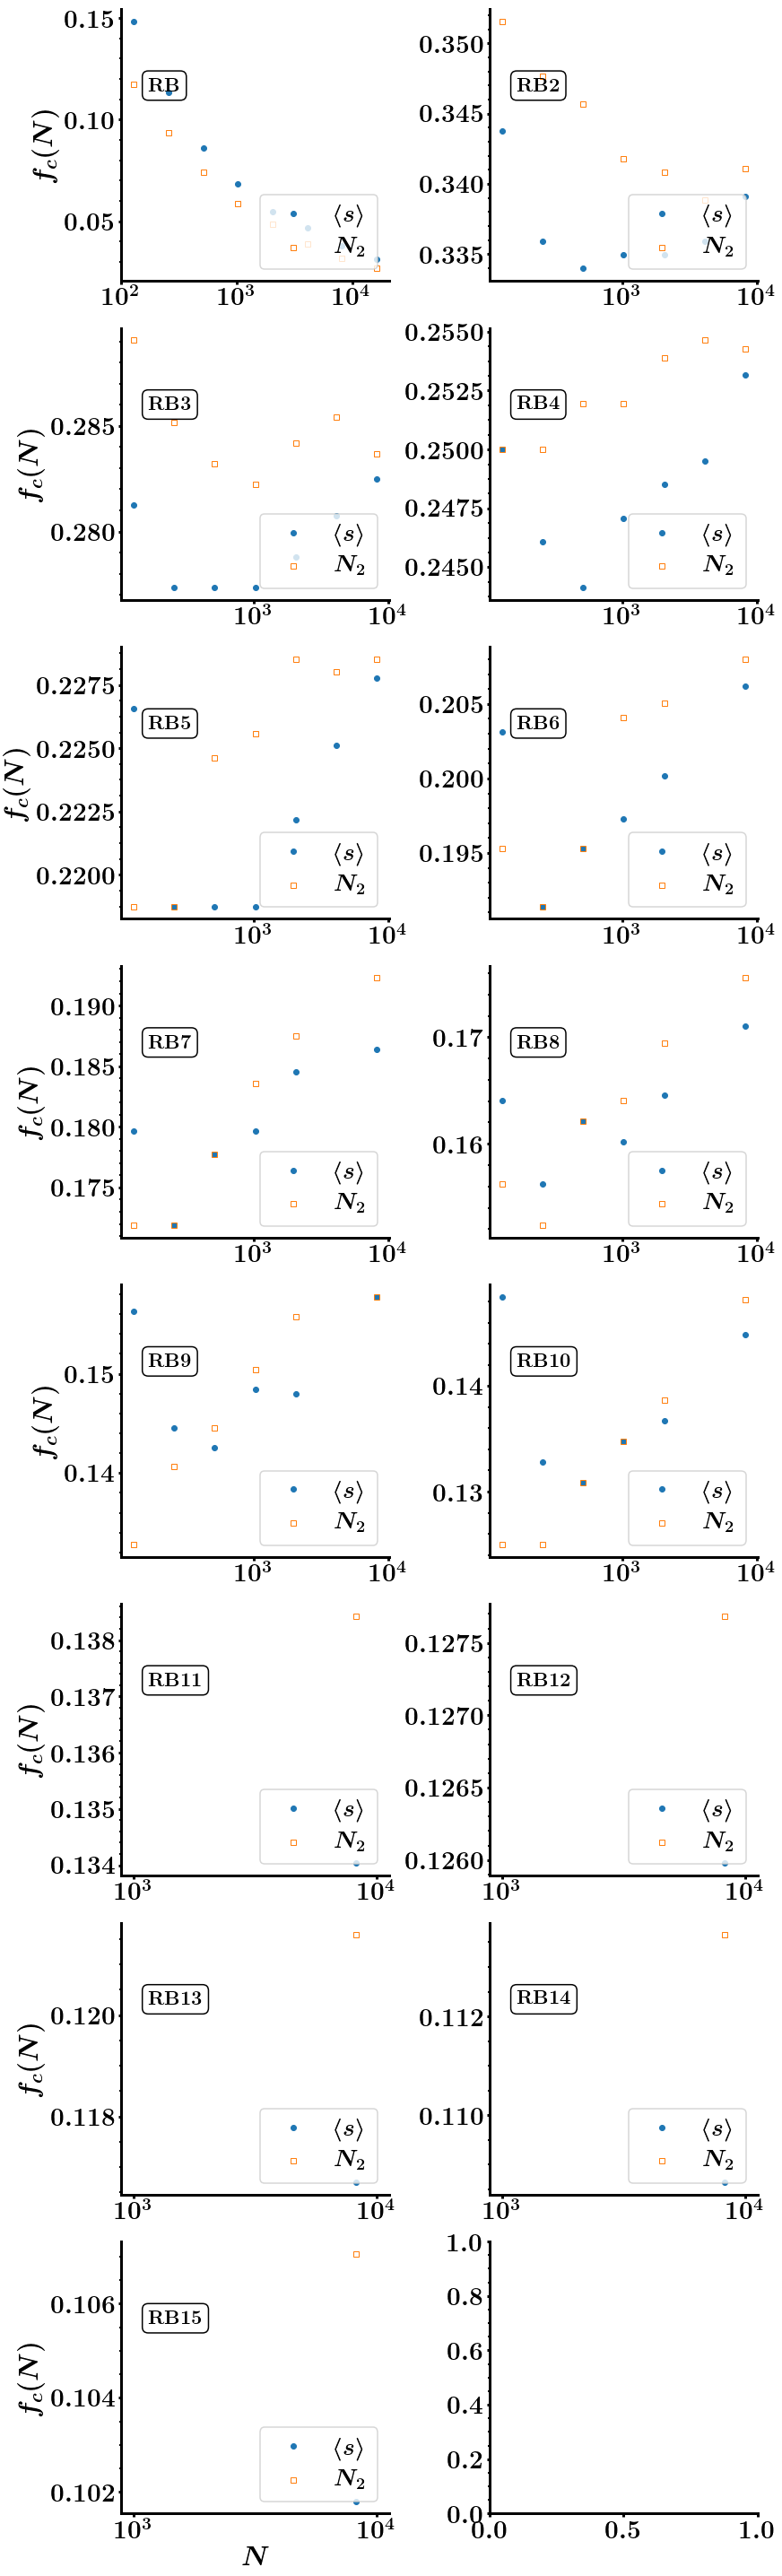

In [17]:
def plot_fc_N():
    from mpl_settings_v3 import colors

    attacks = ['BtwU'] + ['BtwU_cutoff{}'.format(i) for i in range(2, 16)]
    marker_dict = {'meanS': 'o', 'Nsec': 's'}
    color_dict = {'meanS': colors[0], 'Nsec': colors[1]}
    linestyle_dict = {'meanS': '--', 'Nsec': '-.'}
    label_dict = {'meanS': r'$\langle s \rangle$', 'Nsec': r'$N_2$'}

    ncols = 2
    nrows = len(attacks)%2 + len(attacks)//2
    fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()

    for k, attack in enumerate(attacks):

        if attack == 'Ran':
            N_values = [1024, 2048, 4000, 8000, 16000]
        if attack == 'Deg':
            N_values = [1024, 2048, 4000, 8000, 16000]
        elif attack == 'DegU':
            N_values = [1024, 2048, 4000, 8000, 16000]
        elif attack == 'BtwU':
            N_values = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
        elif attack == 'BtwU_cutoff2':
            N_values = [128, 256, 512, 1024, 2048, 4096, 8192]
        elif attack == 'BtwU_cutoff3':
            N_values = [128, 256, 512, 1024, 2048, 4096, 8192]
        elif attack == 'BtwU_cutoff4':
            N_values = [128, 256, 512, 1024, 2048, 4096, 8192]
        elif attack == 'BtwU_cutoff5':
            N_values = [128, 256, 512, 1024, 2048, 4096, 8192]
        elif attack == 'BtwU_cutoff6':
            N_values = [128, 256, 512, 1024, 2048, 8192]
        elif attack == 'BtwU_cutoff7':
            N_values = [128, 256, 512, 1024, 2048, 8192]
        elif attack == 'BtwU_cutoff8':
            N_values = [128, 256, 512, 1024, 2048, 8192]
        elif attack == 'BtwU_cutoff9':
            N_values = [128, 256, 512, 1024, 2048, 8192]
        elif attack == 'BtwU_cutoff10':
            N_values = [128, 256, 512, 1024, 2048, 8192]
        elif attack in ['BtwU_cutoff{}'.format(i) for i in range(11, 16)]:
            N_values = [8192]

        dfs1000, dfs10000, dfs20000, dfsMax = load_dfs(attack, N_values, param, net_type)
        dfs = {}
        _N_values = N_values
        for N in _N_values:
            dfs[N] = dfsMax[N]
        N_values = list(dfs.keys())
        
        measures = ['meanS', 'Nsec']
        #fc = fc_theo
                
        ax = axes[k]
        if k%2 == 0:
            ax.set_ylabel(r'$f_c(N)$')
        if k >= len(attacks) - 1:
            ax.set_xlabel(r'$N$')

        ax.set_xscale('log')
        
        one_over_N_values = 1/np.array(N_values)
        measures = ['meanS', 'Nsec']
        for measure in measures:
            fc_values, peak_values = getPeaks(dfs, measure)
            if measure == 'meanS':
                print(attack, N_values, fc_values)
        
            if measure == 'meanS':
                ax.plot(N_values, fc_values, 'o',  markersize=6, color=colors[0], label=r'$\langle s \rangle$')
            else:
                ax.plot(N_values, fc_values, 's', fillstyle='none', markersize=6, color=colors[1], label=r'$N_2$')
        #ax.axhline(fc, color='grey')

        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(0.1, 0.7, attack_dict[attack], fontsize=22, 
                transform=ax.transAxes, horizontalalignment='left', bbox=bbox)      
    
        ax.legend(loc=4)
    sns.despine()
    plt.tight_layout()

    fig_name = os.path.join(fig_dir, 'fc_N_' + net_type)
    plt.savefig(fig_name + '.png')
    plt.savefig(fig_name + '.pdf')

    plt.show()
    
plot_fc_N()

In [ ]:
N_values = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
#N_values = [16384]
iterations = 100
d_values = {}
for N in N_values:
    diameters = np.zeros(iterations)
    for i in range(iterations):
        g = create_proximity_graph('PDT', N=N)
        d = g.diameter()
        diameters[i] = d
    print(N, diameters.mean())
    d_values[N] = diameters

128 7.71
256 10.41
512 14.13
1024 19.46
2048 26.73
4096 36.67
8192 50.61


In [28]:
N_values = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
#N_values = [16384]
iterations = 10
meanl_values = {}
for N in N_values:
    meanls = np.zeros(iterations)
    for i in range(iterations):
        g = create_proximity_graph('PDT', N=N)
        meanl = g.average_path_length(directed=False)
        meanls[i] = meanl
    print(N, meanls.mean())
    meanl_values[N] = meanls

128 4.026673228346457
256 5.487380514705882
512 7.44437912793542
1024 10.182938508064517
2048 14.015372534501711
4096 19.27681612007784
8192 26.814197756469564
16384 37.22744208280402


In [8]:
np.array([v[0] for k, v in meanl_values.items()])

array([ 4.66154035,  6.17322304,  8.38256024, 10.43276897, 13.68801237,
       18.59008282, 24.75419742, 32.28461804])

In [26]:
## DT
diameters = [9.37, 12.42, 15.94, 20.66, 27.25, 36.01, 48.5, 64.7]
meanls = [4.721,  6.177,  8.102, 10.801, 13.946, 18.562, 24.187, 32.666]

## PDT
diameters = [7.71, 10.41, 14.13, 19.46, 26.73, 36.67, 50.61]
meanls = [4.027,  5.487,  7.444, 10.183, 14.015, 19.277, 26.814, 37.227]

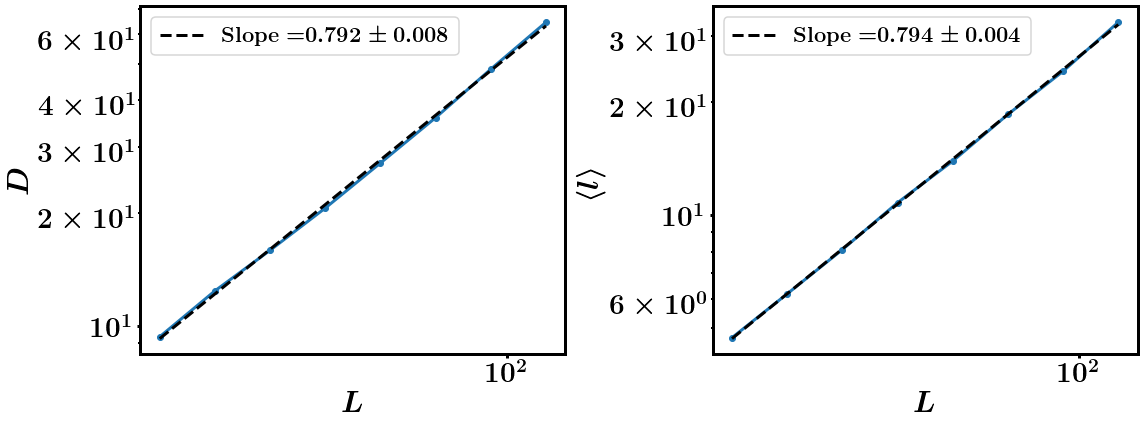

In [27]:
N_values =  [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
L_values = np.sqrt(N_values)
X = L_values

fig, axes = plt.subplots(figsize=(16,6), ncols=2)

ax = axes[0]
ax.set_ylabel(r'$D$')
ax = axes[1]
ax.set_ylabel(r'$\langle l \rangle$')

for ax, Y in zip(axes, [diameters, meanls]):

    ax.set_xlabel(r'$L$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot(X, Y, 'o-')

    Y_pred, slope, y_err = getLinearReg(X, Y)    
    c = Y[0] / X[0]**slope
    label = r'$\mathrm{Slope} = $' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
    ax.plot(X, Y_pred, '--', color='k', label=label)
    ax.legend(fontsize=22)

plt.tight_layout()

fig_name = os.path.join(fig_dir, 'D_and_meanl_vs_L_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

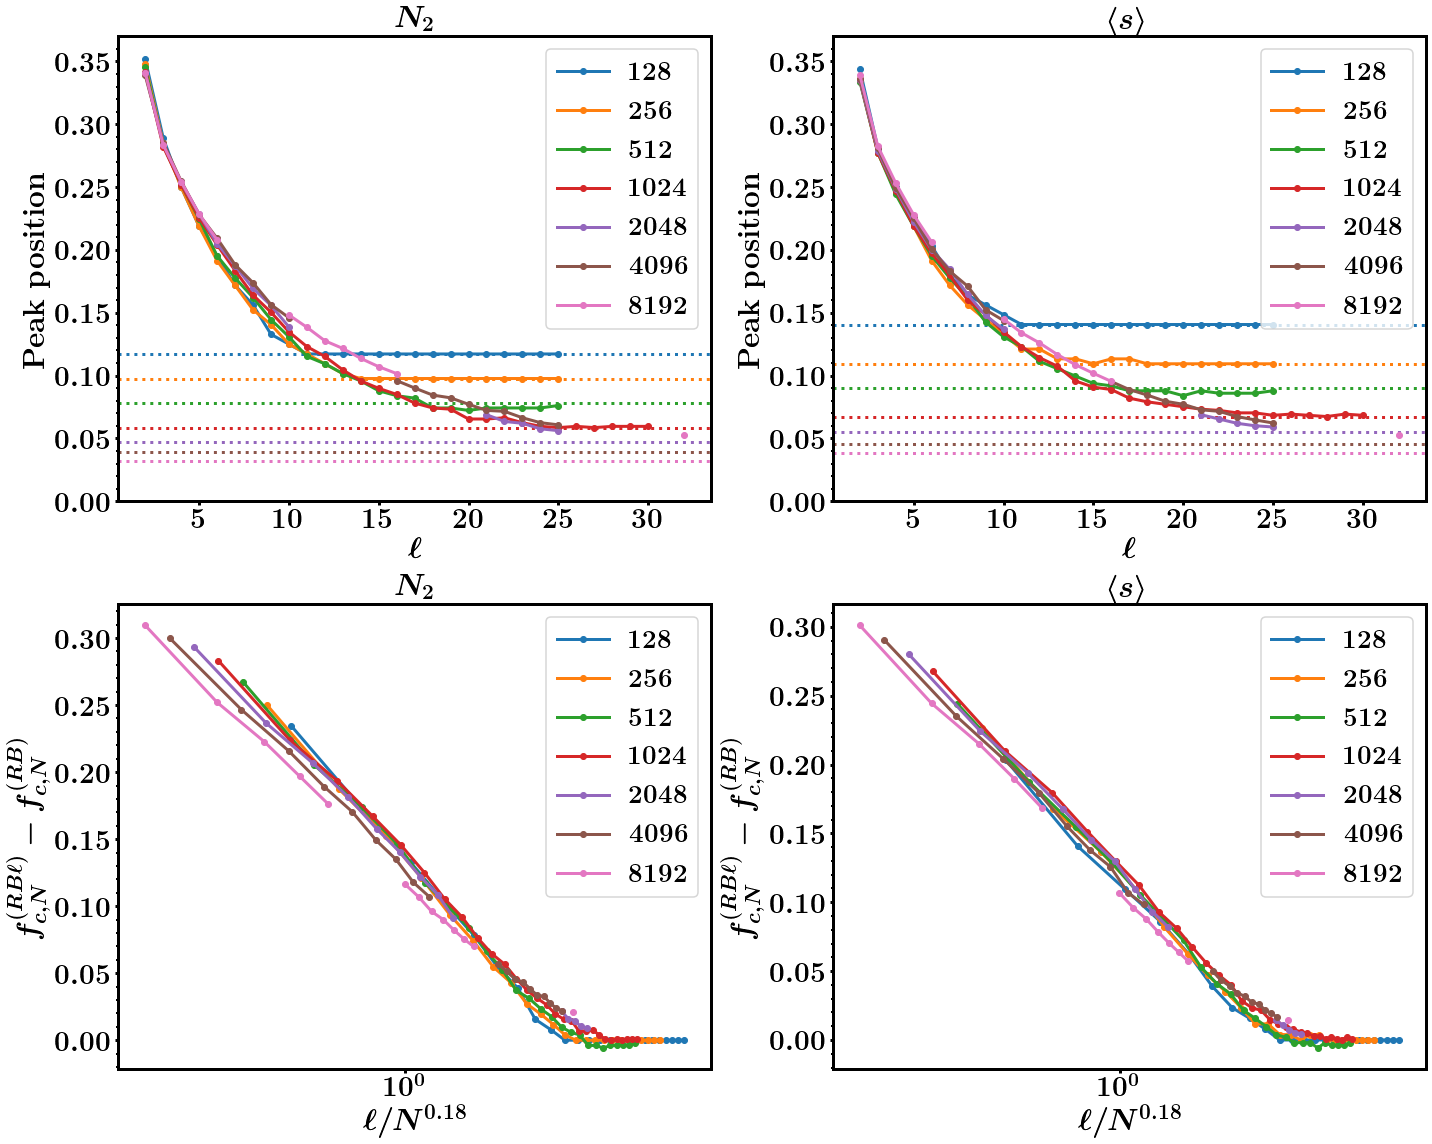

In [3]:
from mpl_settings_v3 import colors 

net_type = 'DT'
param = 'param'
#attacks = ['BtwU_cutoff{}'.format(i) for i in range(2, 6)]
n_seeds = 10000
N_values = [128, 256, 512, 1024, 2048, 4096, 8192]
Bi_range = np.arange(2, 70)
measures = ['Nsec',  'meanS']
peak_positions = {}
peak_positions_inf = {}
for measure in measures:
    peak_positions[measure] = {}
    peak_positions_inf[measure] = {}
    for N in N_values:
        peak_positions[measure][N] = []
        for l in Bi_range:
            attack = 'BtwU_cutoff{}'.format(l)
            try:
                df = load_dataframe(attack, N, param, net_type=net_type, fast=True, n_seeds=n_seeds)
                idx = df[measure].idxmax()
                peak_pos = df.f[idx]
            except:
                try:
                    df = load_dataframe(attack, N, param, net_type=net_type, fast=True, n_seeds=n_seeds//10)
                    idx = df[measure].idxmax()
                    peak_pos = df.f[idx]
                except:
                    peak_pos = np.NaN

            
            peak_positions[measure][N].append(peak_pos)
        attack = 'BtwU'
        try:
            df = load_dataframe(attack, N, param, net_type=net_type, fast=True, n_seeds=n_seeds)
        except:
            pass
        try:
            df = load_dataframe(attack, N, param, net_type=net_type, fast=True, n_seeds=n_seeds//10)
        except:
             pass
        #    df = load_dataframe(attack, N, param, net_type=net_type, fast=True, n_seeds=n_seeds//100)
        
        idx = df[measure].idxmax()
        peak_pos = df.f[idx]
        peak_positions_inf[measure][N] = peak_pos


ncols = 2
nrows = 2
fig, all_axes = plt.subplots(figsize=(10*ncols,8*nrows), ncols=ncols, nrows=nrows)

axes = all_axes[0]
for j, measure in enumerate(measures):
    ax = axes[j]
    #ax.set_xlim(1, 5)
    #ax.set_ylim(0.2, 0.3)
    ax.set_ylim(0, 0.37)
    ax.set_xlabel(r'$\ell$')
    ax.set_ylabel(r'$\mathrm{Peak\;position}$')
    ax.set_title(measures_dict[measure], fontsize=30)
    for i, N in enumerate(N_values):
        #ax.set_yscale('log')
        #ax.set_xscale('log')
        #ax.axvline(diameters[i], linestyle='--', color=colors[i])
        ax.plot(Bi_range, peak_positions[measure][N], 'o-', 
        #ax.plot(Bi_range, peak_positions[measure][N]-peak_positions_inf[measure][N], 'o-', 
                color=colors[i], label=r'${{{}}}$'.format(N))
        #ax.scatter(0, meanS_peak_positions_inf[measure][N], color=colors[i])
        ax.axhline(peak_positions_inf[measure][N], linestyle=':', color=colors[i])
    ax.legend()
    
axes = all_axes[1]
for j, measure in enumerate(measures):
    ax = axes[j]
    #ax.set_xlabel(r'$\ell/D$')
    ax.set_xlabel(r'$\ell/N^{0.18}$')
    #ax.set_ylabel(r'$\mathrm{Relative\;peak\;position}$')
    ax.set_ylabel(r'$f^{(RB\ell)}_{c,N} - f^{(RB)}_{c,N}$')
    ax.set_title(measures_dict[measure], fontsize=30)
    for i, N in enumerate(N_values):
        #ax.set_yscale('log')
        ax.set_xscale('log')
        ax.plot(#Bi_range/diameters[i], 
                #Bi_range/np.sqrt(N), 
                (Bi_range-0.5)/N**0.25,
                peak_positions[measure][N] - peak_positions_inf[measure][N], 'o-', 
                #peak_positions[measure][N], 'o-', 
        #ax.plot((peak_positions[measure][N] - peak_positions_inf[measure][N]),
        #        Bi_range/d_values[N].mean(), 'o-', 
                color=colors[i], label=r'${{{}}}$'.format(N))
    X = np.logspace(-1, 0)
    #ax.plot(X, -np.log(1*X)/8, ':', color='k')
    ax.legend()
    
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'peak_shifting_RBl_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.tight_layout()
plt.show()

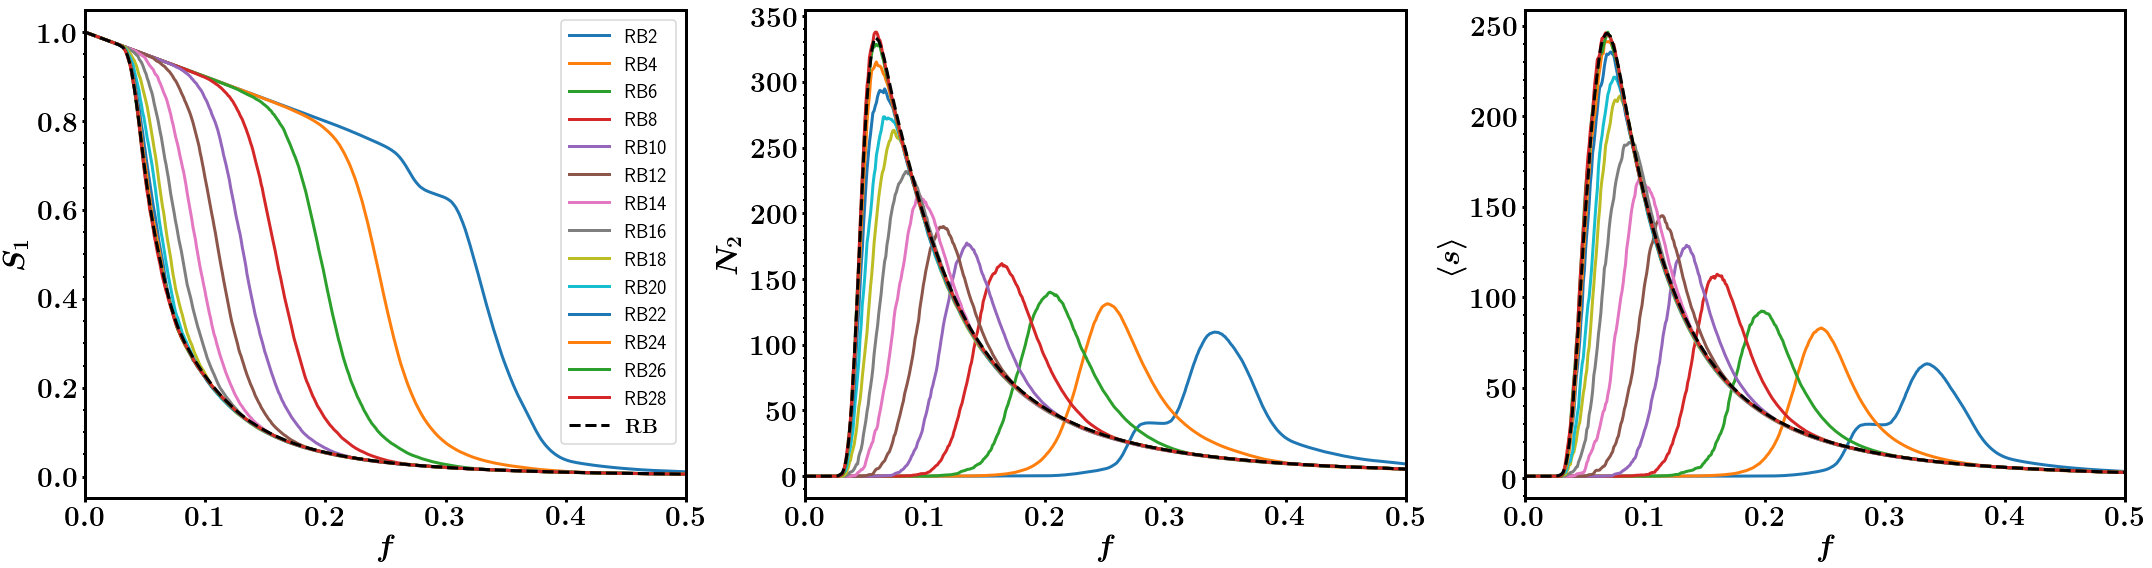

In [350]:
fig, axes = plt.subplots(figsize=(30, 8), ncols=3)
axes[0].set_ylabel(r'$S_1$')
axes[1].set_ylabel(r'$N_2$')
axes[2].set_ylabel(r'$\langle s \rangle$')
for ax in axes:
    ax.set_xlabel(r'$f$')
    ax.set_xlim(0, 0.5)
N = 1024
for l in Bi_range:
    if l%2 != 0:
        continue
    attack = 'BtwU_cutoff{}'.format(l)
    try:
        df = load_dataframe(attack, N, param, net_type=net_type, fast=True, n_seeds=n_seeds)
    except:
        try:
            df = load_dataframe(attack, N, param, net_type=net_type, fast=True, n_seeds=n_seeds//10)
        except:
            continue
    axes[0].plot(df.f, df.Sgcc, label='RB{}'.format(l))
    axes[1].plot(df.f, df.Nsec)
    axes[2].plot(df.f, df.meanS)

attack = 'BtwU'
try:
    df = load_dataframe(attack, N, param, net_type=net_type, fast=True, n_seeds=n_seeds)
except:
    df = load_dataframe(attack, N, param, net_type=net_type, fast=True, n_seeds=n_seeds//10)
axes[0].plot(df.f, df.Sgcc, '--', color='k', label=attack_dict[attack])
axes[1].plot(df.f, df.Nsec, '--', color='k')
axes[2].plot(df.f, df.meanS, '--', color='k')

axes[0].legend(fontsize=20)

plt.tight_layout()

fig_name = os.path.join(fig_dir, 'order_par_and_susceptibility_RBl_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

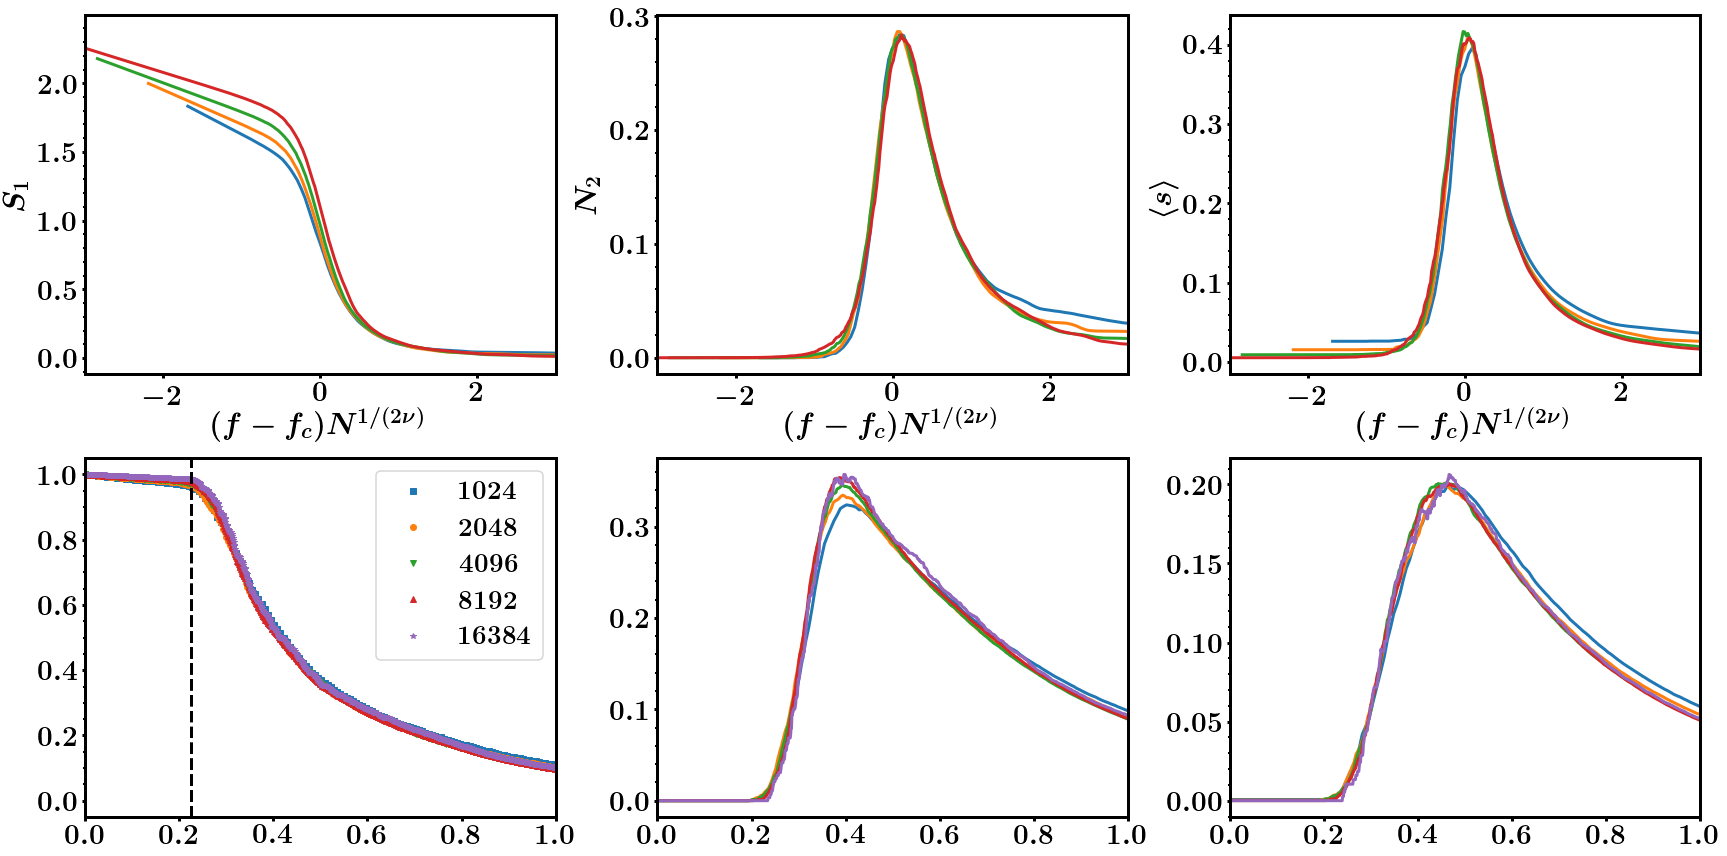

In [358]:
fc_values = {
    2: 0.345,
    3: 0.274,
    4: 0.267,
    5: 0.230
}

ncols = 3
nrows = 2
fig, all_axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
axes = all_axes[0]
axes[0].set_ylabel(r'$S_1$')
axes[1].set_ylabel(r'$N_2$')
axes[2].set_ylabel(r'$\langle s \rangle$')
for ax in axes:
    ax.set_xlabel(r'$(f-f_c)N^{1/(2\nu)}$')
    #ax.set_xlim(0, 0.5)
    ax.set_xlim(-3, 3)
    #ax.set_yscale('log')
    #ax.set_ylim(1, 400)
for j, N in enumerate([128, 256, 512, 1024]):
    for i, l in enumerate(Bi_range):
        
        if l not in [3]:
            continue
        
        attack = 'BtwU_cutoff{}'.format(l)
        try:
            df = load_dataframe(attack, N, param, net_type=net_type, fast=True, n_seeds=n_seeds)
        except:
            pass
        try:
            df = load_dataframe(attack, N, param, net_type=net_type, fast=True, n_seeds=n_seeds//10)
        except:
            df = load_dataframe(attack, N, param, net_type=net_type, fast=True, n_seeds=n_seeds//100)

        #beta = 1.39
        #gamma = 2.389
        beta = 0.333
        gamma = 2
        nu = 4/3
        axes[0].plot((df.f-fc_values[l])*N**(1/(2*nu)), df.Sgcc*N**(beta/(2*nu)), color=colors[j])
        axes[1].plot((df.f-fc_values[l])*N**(1/(2*nu)), df.Nsec*N**(beta/(2*nu)-1), color=colors[j])
        axes[2].plot((df.f-fc_values[l])*N**(1/(2*nu)), df.meanS*N**(-gamma/(2*nu)), color=colors[j])

axes = all_axes[1]
for ax in axes:
    ax.set_xlim(0, 1)
    
for i, N in enumerate([1024, 2048, 4096, 8192, 16384]):
    
    attack = 'BtwU'
    try:
        df = load_dataframe(attack, N, param, net_type=net_type, fast=True, n_seeds=n_seeds)
    except:
        pass
    try:
        df = load_dataframe(attack, N, param, net_type=net_type, fast=True, n_seeds=n_seeds//10)
    except:
        df = load_dataframe(attack, N, param, net_type=net_type, fast=True, n_seeds=n_seeds//100)

    nu = 1.8
    beta = 0
    gamma = 3.7
        
    axes[0].plot(df.f*N**(1/(2*nu)), df.Sgcc*N**(beta/(2*nu)), linestyle='', marker=markers[i], 
                 label=r'${{{}}}$'.format(N))#, color='k')
    axes[0].axvline(0.225, linestyle='--', color='k')
    axes[1].plot(df.f*N**(1/(2*nu)), df.Nsec*N**(beta/(2*nu)-1), '-')#, color='k')
    axes[2].plot(df.f*N**(1/(2*nu)), df.meanS*N**(-gamma/(2*nu)), '-')#, color='k')

axes[0].legend()
plt.tight_layout()
#axes[0].legend()

TypeError: unsupported format string passed to NoneType.__format__

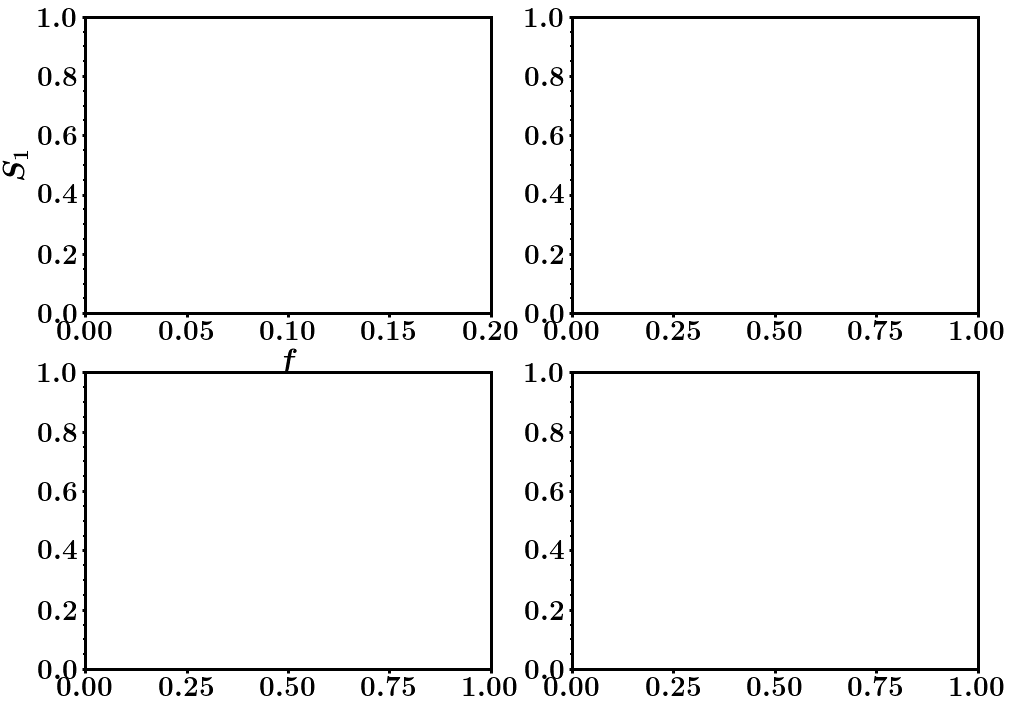

In [4]:
ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for i, ax in enumerate(axes.flatten()):

    if i == 0:
        ax.set_xlim(0, 0.2)
        ax.set_xlabel(r'$f$')
        ax.set_ylabel(r'$S_1$')
    else:
        ax.set_xlim(0, 1)
        ax.set_ylim(0.1, 1.05)
        ax.set_ylabel(r'$S_1 N^{\beta/()}$')
        ax.set_xlabel(r'$(f -f_c) N^{1/(2\nu)}$')
    for N in [1024, 2048, 4096, 8192, 16384]:

        attack = 'BtwU'
        df = load_dataframe(attack, N, param, net_type=net_type, fast=True)

        if i == 0:
            ax.plot(df.f, df.Sgcc, linestyle='', marker=markers[i], markersize=3,
                label=r'${{{}}}$'.format(N))#, color='k')
        else:   
            #nu = 1.666
            nu = 1.4 + 0.2*i
            ax.plot(df.f*N**(1/(2*nu)), df.Sgcc, linestyle='', marker=markers[i], markersize=3,
                label=r'${{{}}}$'.format(N))#, color='k')
            ax.text(0.05, 0.15, r'$\nu = {{{:.3f}}}$'.format(nu), 
                    transform=ax.transAxes, fontsize=26)
    ax.legend(fontsize=22)
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'Sgcc_scaling_RB_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

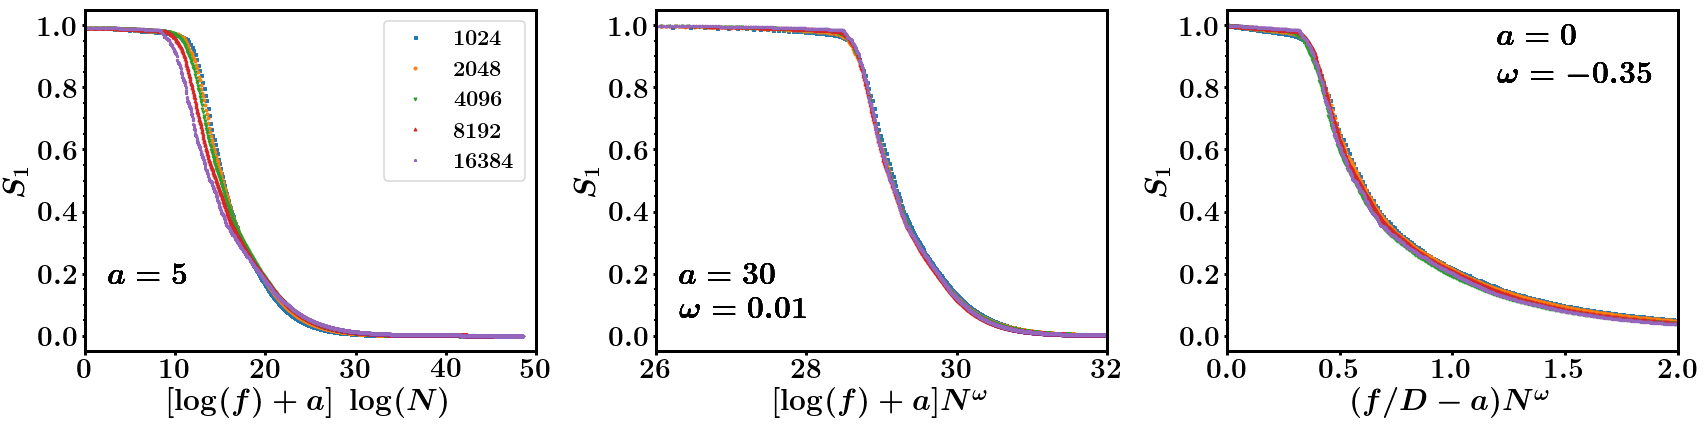

In [397]:
ncols = 3
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

axes = axes.flatten()

ax = axes[0]
ax.set_ylabel(r'$S_1$')
ax.set_xlabel(r'$[\log(f) + a]\;\log(N)$')
ax.set_xlim(0, 50)

ax = axes[1]
ax.set_ylabel(r'$S_1$')
ax.set_xlabel(r'$[\log(f) + a]N^{\omega}$')
ax.set_xlim(26, 32)

for i, N in enumerate([1024, 2048, 4096, 8192, 16384]):

    attack = 'BtwU'
    try:
        df = load_dataframe(attack, N, param, net_type=net_type, fast=True, n_seeds=n_seeds)
    except:
        pass
    try:
        df = load_dataframe(attack, N, param, net_type=net_type, fast=True, n_seeds=n_seeds//10)
    except:
        df = load_dataframe(attack, N, param, net_type=net_type, fast=True, n_seeds=n_seeds//100)
    
    ax = axes[0]
    a = 5
    e2 = 0.00
    ax.plot(
        (np.log(df.f[1:])+a)*np.log(N), df.Sgcc[1:]*N**e2, linestyle='', 
        marker=markers[i], markersize=3, label=r'${{{}}}$'.format(N)
    )
    ax.text(0.05, 0.2, r'$a = {{{:.0f}}}$'.format(a), transform=ax.transAxes, fontsize=30)
    ax.legend(fontsize=22)
    ax = axes[1]
    e = 0.01
    a = 30
    e2 = 0.00
    ax.plot(
        (np.log(df.f[1:])+a)*N**e, df.Sgcc[1:], linestyle='', 
        marker=markers[i], markersize=3, label=r'${{{}}}$'.format(N)
    )
    ax.text(0.05, 0.2, r'$a = {{{:.0f}}}$'.format(a), transform=ax.transAxes, fontsize=30)
    ax.text(0.05, 0.1, r'$\omega = {{{:.2f}}}$'.format(e), transform=ax.transAxes, fontsize=30)
    
    if False:
        ax = axes[3]
        ax.set_ylabel(r'$S_1$')
        ax.set_xlabel(r'$(f N - a) N^{-0.5}$')
        #ax.set_xlim(0, 10)
        a = 500
        ax.plot(
            (df.f*N-a)/N**0.5, df.Sgcc, linestyle='', 
            marker=markers[i], markersize=3, label=r'${{{}}}$'.format(N)
        )  
        ax.text(0.05, 0.2, r'$a = {{{:.0f}}}$'.format(a), transform=ax.transAxes, fontsize=30)
        ax.text(0.05, 0.1, r'$\omega = {{{:.2f}}}$'.format(e), transform=ax.transAxes, fontsize=30)
    
    ax = axes[2]
    ax.set_ylabel(r'$S_1$')
    ax.set_xlabel(r'$(f/D-a) N^\omega$')
    #ax.set_xlim(0, 50)
    ax.set_xlim(0, 2)
    a = 0
    e = -0.35
    ax.plot(
        (df.f*N/diameters[i]-a)*N**e, df.Sgcc, linestyle='', 
        marker=markers[i], markersize=3, label=r'${{{}}}$'.format(N)
    )  
    ax.text(0.6, 0.9, r'$a = {{{:.0f}}}$'.format(a), transform=ax.transAxes, fontsize=30)
    ax.text(0.6, 0.8, r'$\omega = {{{:.2f}}}$'.format(e), transform=ax.transAxes, fontsize=30)

plt.tight_layout()
fig_name = os.path.join(fig_dir, 'Sgcc_scaling_RB_f_renormalized_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

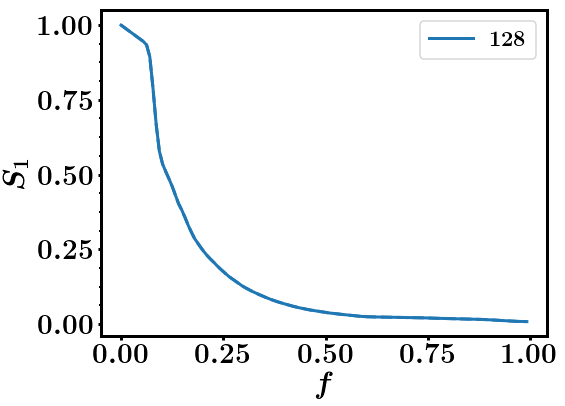

In [21]:
net_type = 'DT'
param = 'param'
n_seeds = 1000
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax.set_ylabel(r'$S_1$')
#ax.set_xlim(0, 0.2)
ax.set_xlabel(r'$f$')

for j, N in enumerate([128]):

    linestyles = ['-', '--']
    labels = [r'${{{}}}$'.format(N), '']
    for i, attack in enumerate(['BtwWU', 'BtwWU_cutoff2']):
        try:
            df = load_dataframe(attack, N, param, net_type=net_type, fast=True, n_seeds=n_seeds)
        except:
            df = load_dataframe(attack, N, param, net_type=net_type, fast=True, n_seeds=n_seeds//10)

        ax.plot(df.f, df.Sgcc, linestyles[i], color=colors[j], label=labels[i])#, marker=markers[i], markersize=3,
                #label=r'${{{}}}$'.format(N))#, color='k')

ax.legend(fontsize=22)
#plt.tight_layout()
#fig_name = os.path.join(fig_dir, '{}_RB_scaling_nu'.format(net_type, nu))
#plt.savefig(fig_name + '.png')
#plt.savefig(fig_name + '.pdf')
plt.show()

Nsec [0.1171875, 0.09765625, 0.078125, 0.05859375, 0.04736328125, 0.038330078125, 0.0313720703125]
meanS [0.140625, 0.109375, 0.08984375, 0.0673828125, 0.0546875, 0.04345703125, 0.035400390625]


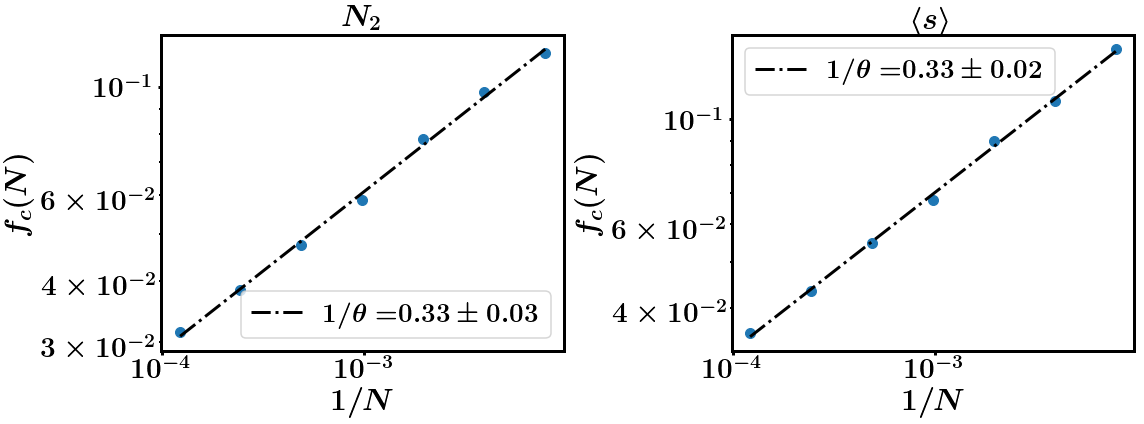

[0.1328125, 0.140625, 0.14453125, 0.150390625, 0.15576171875, 0.156494140625, 0.15771484375]
[-0.13858749999999997, -0.13077499999999997, -0.12686874999999997, -0.12100937499999997, -0.11563828124999997, -0.11490585937499997, -0.11368515624999997]


/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/ipykernel/__main__.py:186: RuntimeWarning: invalid value encountered in log
/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/ipykernel/__main__.py:187: RankWarning: Polyfit may be poorly conditioned


ValueError: operands could not be broadcast together with shapes (2,2) (0,) 

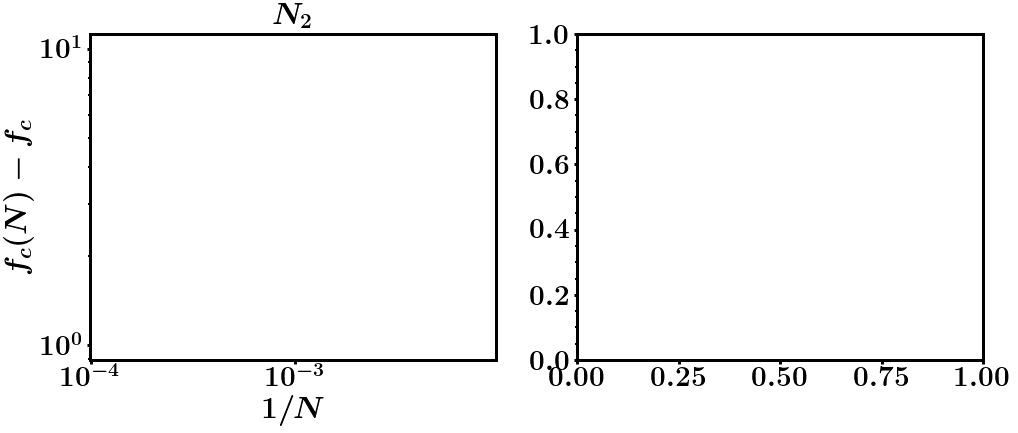

In [38]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)
for i, measure in enumerate(measures):
    ax = axes[i]
    ax.set_title(measures_dict[measure], fontsize=30)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$1/N$')
    ax.set_ylabel(r'$f_c(N)$')
    X = 1/np.array(N_values)
    Y = [peak_positions_inf[measure][N] for N in N_values]
    ax.plot(X, Y, 'o', markersize=10)
    print(measure, Y)
    Y_pred, slope, y_err = getLinearReg(X, Y)
    
    c = Y[0] / X[0]**slope
    label = r'$1/\theta = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
    ax.plot(X, Y_pred, '-.', color='k', label=label)
    ax.legend()

plt.tight_layout()
fig_name = os.path.join(fig_dir, 'nu_scaling_RB_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

l = 2
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)
for i, measure in enumerate(measures):
    ax = axes[i]
    ax.set_title(measures_dict[measure], fontsize=30)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$1/N$')
    ax.set_ylabel(r'$f_c(N)-f_c$')
    X = 1/np.array(N_values)
    #Y = [peak_positions[measure][N][0]-0.334 for N in N_values]
    Y = [peak_positions[measure][N][7]-0.2714 for N in N_values]
    #Y = [peak_positions[measure][N][2]-0.242 for N in N_values]
    print([peak_positions[measure][N][7] for N in N_values])
    print(Y)
    ax.plot(X, Y, 'o', markersize=7)
    
    Y_pred, slope, y_err = getLinearReg(X, Y)
    
    c = Y[0] / X[0]**slope
    label = r'$1/\theta = $' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
    ax.plot(X, Y_pred, '-.', color='k', label=label)
    ax.legend()
plt.tight_layout()
plt.show()

In [260]:
h = ig.Graph().Erdos_Renyi(100, 0.01)
g = h.copy()
print(g.summary())
g.delete_vertices(0)
print(g.vcount(), h.vcount())

IGRAPH U--- 100 42 -- 
99 100


In [344]:
def cayley_tree(order, depth):
    if depth == 0:
        return ig.Graph(1)
    if depth == 1:
        return ig.Graph.Tree(order+1, order)
    d = order - 1
    n1, n2 = d ** (depth+1) - 1, d ** depth - 1
    n1 = n1 // d-1
    n2 = n2 // d-1
    return ig.Graph.Tree(n1, d) + ig.Graph.Tree(n2, d) 


g = cayley_tree(3, 2)
g.summary()

'IGRAPH U--- 2 1 -- '

In [352]:
g = ig.Graph.Tree(13, 2)
print(g.summary())
layout = g.layout('tree')
ig.plot(g, layout=layout)

IGRAPH U--- 13 12 -- 


AttributeError: 'bytes' object has no attribute 'encode'

In [3]:

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

#c1='#1f77b4' #blue
c1 = 'black'
c2='white' #green

def get_btw_colormap(btw_values, bins):

    bin_size = max(btw_values) / bins
    bin_size
    
    membership = [int(b/bin_size) for b in btw_values]
    
    btw_colors = [colorFader(c1,c2,x/bins) for x in membership]

    return membership, btw_colors

In [13]:
N = 10000
g = create_proximity_graph('DT', N=N)
position = np.array(g.vs['position'])
btw_values = g.betweenness(directed=False)

In [5]:
bins = 10
membership, btw_color = get_btw_colormap(btw_values, bins)
g.vs['color'] = btw_color

In [6]:
from planar import distance
edge_weights = []
for e in g.es():
    s,t = e.tuple
    #print(position[s], position[t], distance(s,t,position))
    edge_weights.append(distance(s,t,position))
    
w_btw_values = g.betweenness(directed=False, weights=edge_weights, nobigint=False)
btw_values = g.betweenness(directed=False, nobigint=False)

In [16]:
sorted_btw_values = sorted([(p, b) for (p, b) in zip(position, btw_values)], key=lambda x: x[1])

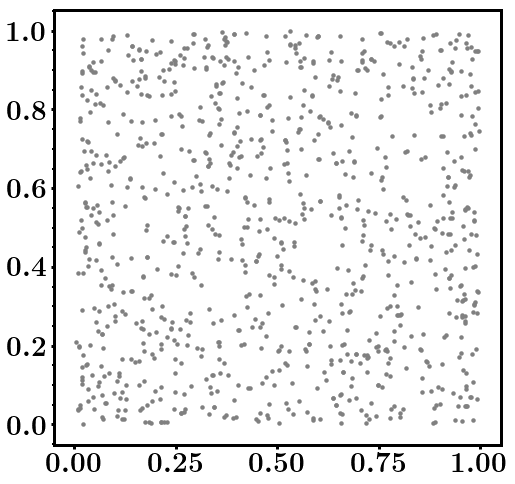

In [25]:
from matplotlib import collections  as mc

lines = []
for e in g.es():
    s, t = e.tuple
    line = (g.vs(s)['position'][0], g.vs(t)['position'][0])
    lines.append(line)

c_values = [(1,0,0,1)]*(N//2) + [(0,1,0,1)]*(N//2)    
#_colors = ['k' if b > 0.9*max(btw_values) else 'white' for b in btw_values]
#lc = mc.LineCollection(lines, colors='grey', linewidth=1, linestyle='-')#, colors=btw_color, linewidths=membership)
fig, ax = plt.subplots(figsize=(8,8))
#ax.add_collection(lc)
#for i, (x,y) in enumerate(position):
for (i, ((x,y), b)) in enumerate(sorted_btw_values):
    if i > 0.1*N:
        continue
    #ax.scatter(x,y, color=btw_color[i], marker='o')
    #c = 'k' if btw_values[i] >0.9*max(btw_values) else 'grey'
    #m = 'o' if btw_values[i] >0.9*max(btw_values) else '.'
    c = 'k' if i > 0.9*N else 'grey'
    m = '.' if i > 0.9*N else '.'
    ax.scatter(x,y, color=c, marker=m)

ax.autoscale()
ax.margins(0.05)

plt.show()

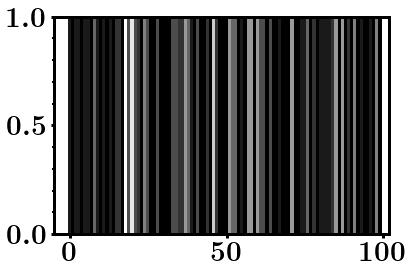

In [68]:
for i in range(N):
    plt.axvline(i, color=btw_color[i], linewidth=4)

In [49]:
N = 100
g = ig.Graph().Lattice(dim=[N], circular=False)
print(g.summary())

h = g.copy()
h.add_edges([(20, 30)])
print(h.summary())

btw_values_g = {}
btw_values_h = {}

btw_values_g['inf'] = g.betweenness()
btw_values_h['inf'] = h.betweenness()
l_values = np.arange(2, 10)
l_values = [10, 50, 100]
for l in l_values:
    btw_values_g[l] = g.betweenness(cutoff=l)
    btw_values_h[l] = h.betweenness(cutoff=l)

IGRAPH U--- 100 99 -- 
IGRAPH U--- 100 100 -- 


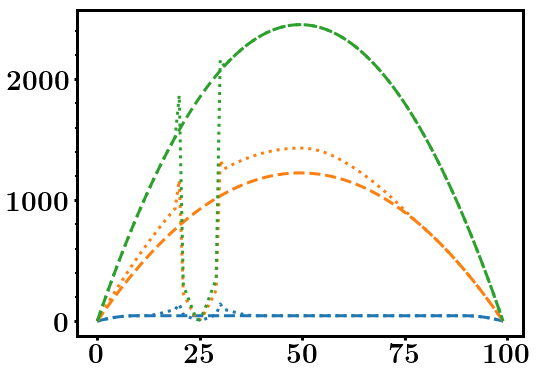

In [50]:
ncols=1
nrows=1
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)
#print(np.histogram(btw_values))
ax = axes
#ax.plot(range(N), btw_values_g['inf'])
for i, l in enumerate(l_values): 
    ax.plot(range(N), btw_values_g[l], color=colors[i], linestyle='--', label=l)
    ax.plot(range(N), btw_values_h[l], color=colors[i], linestyle=':')
plt.show()

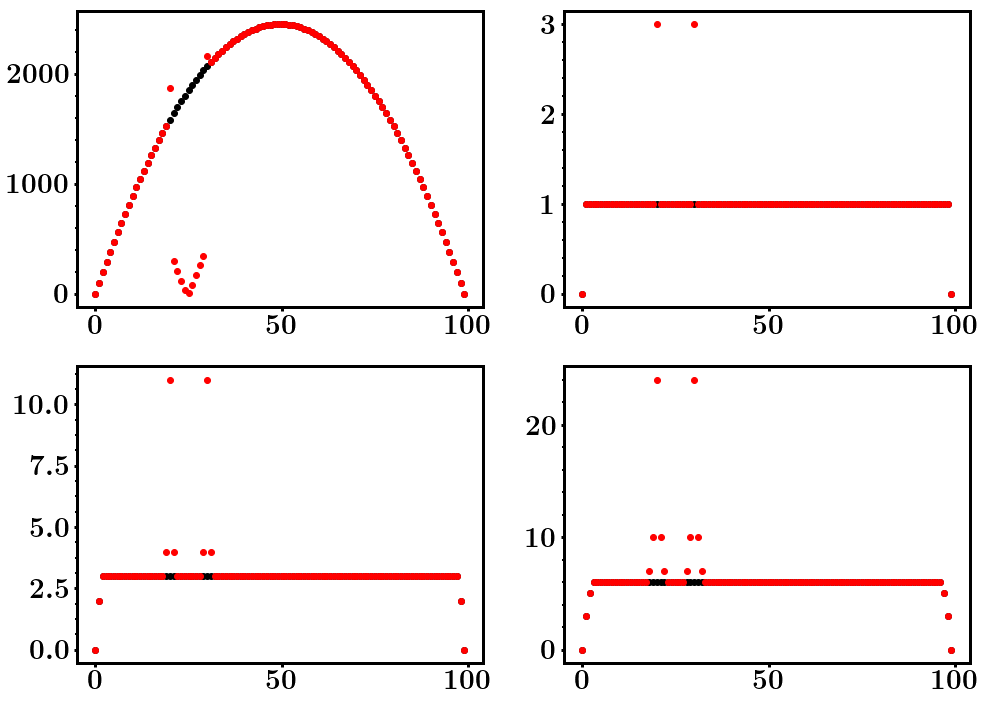

In [38]:
ncols=2
nrows=2
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)
#print(np.histogram(btw_values))
ax = axes[0][0]
ax.plot(range(N), btw_values_g['inf'], 'o', color='k')
ax.plot(range(N), btw_values_h['inf'], 'o', color='red')

for i, ax in enumerate(axes.flatten()[1:]):
    l = i + 2
    ax.plot(range(N), btw_values_g[l], 'o', color='k')
    ax.plot(range(N), btw_values_h[l], 'o', color='red')
plt.show()

In [205]:
N = 100000
meank = 4
p = meank / N
g = ig.Graph().Erdos_Renyi(N, p)

D = g.diameter()
print(D)

18


In [206]:
l_values = [2, 3, 4, 5, 6, 7, 8, 10, 16]
btw_cutoff_values = {}
for l in l_values:
    print(l)
    btw_cutoff_values[l] = g.betweenness(directed=False, cutoff=l)

2
3
4
5
6
7
8


KeyboardInterrupt: 

KeyError: 8

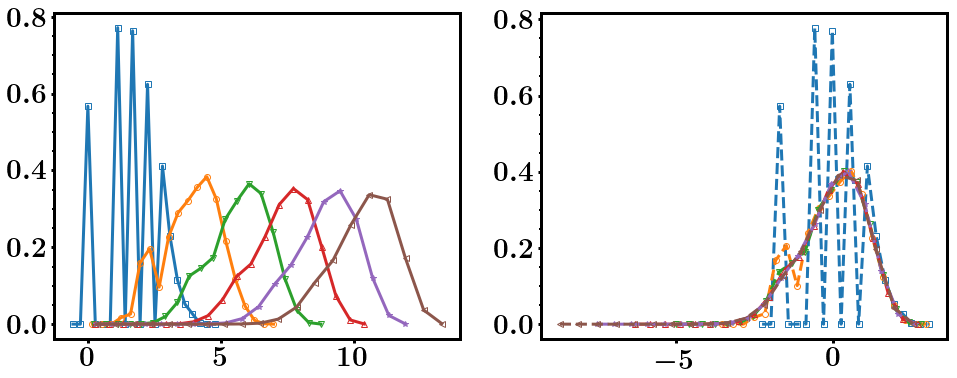

In [207]:
ncols = 2
fig, axes = plt.subplots(figsize=(8*ncols,6), ncols=ncols)

for i, l in enumerate(l_values):
    btw_values = np.array(btw_cutoff_values[l])
    btw_values = btw_values[btw_values>0]
    log_btw_values = np.log(btw_values)
    hist, bin_edges = np.histogram(log_btw_values, bins=20, normed=True)
    bin_centers = ( bin_edges[:-1] + bin_edges[1:] ) / 2
    #hist_QL = bin_centers*hist
    #QL = np.log(bin_centers)
    QL = hist
    axes[0].plot(bin_centers, QL, '-', marker=markers[i], fillstyle='none', label=r'$l = {{{}}}$'.format(l))
    
    
    mu = np.mean(log_btw_values)
    sigma = np.std(log_btw_values)
    u = (bin_centers - mu) / sigma
    #u = QL
    #u = (QL - np.mean(QL))
    Q = sigma*QL
    #Q = QL
    
    #print(u)
    axes[1].plot(u, Q, linestyle='--', marker=markers[i], fillstyle='none')
    
ax = axes[0]
ax.set_xlabel(r'$\ln(B)$')
ax.set_ylabel(r'$Q_L$')    
ax.legend(fontsize=12)

ax = axes[1]
ax.set_xlim(-5, 3)
ax.set_xlabel(r'$u$')
ax.set_ylabel(r'$Q$')

plt.tight_layout()
plt.show()

In [64]:
df1 = pd.read_csv('../networks/DT/DT_param/DT_param_N1000/properties_BtwU_nSeeds100_cpp.csv')
df2 = pd.read_csv('../networks/DT/DT_param/DT_param_N1000/BtwU_nSeeds100_cpp.csv')

BtwU
128
256
DegU
128
256


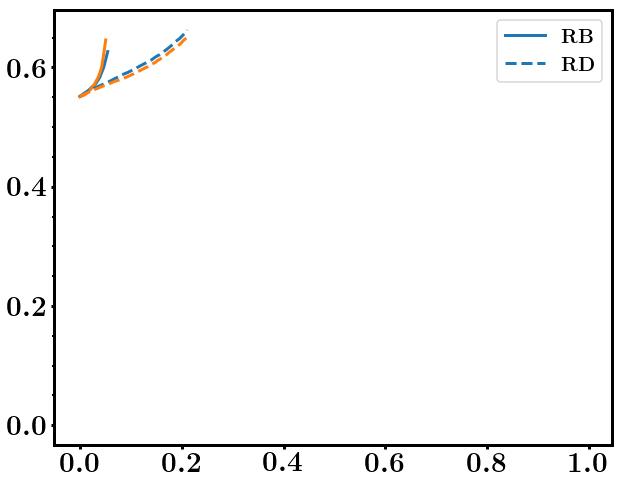

In [156]:
#plt.plot(df1.f, df1.Ngcc/1000)
#plt.plot(df2.f, df2.Sgcc, '--')

n_seeds_N = {
    125: 100,
    128: 100,
    250: 100,
    256: 100,
    500: 100,
    1000: 100
}
linestyles = ['-', '--', '-.', ':']
attacks = ['BtwU', 'DegU']#, 'BtwU_cutoff2', 'BtwU_cutoff3']
plt.figure(figsize=(10,8))
for i, attack in enumerate(attacks):
    print(attack)
    for j, N in enumerate([128, 256]):
        print(N)
        df = pd.read_csv('../networks/DT/DT_param/DT_param_N{}/properties_{}_nSeeds{}_cpp.csv'.format(
            N, attack, n_seeds_N[N]))
        if j == 0:
            label = attack_dict[attack]
        else:
            label = ''
        alpha = 0.5
        nu = 1.8
        #plt.plot(df.f, df.D/N**alpha, color=colors[j], linestyle=linestyles[i], label=label)
        #plt.plot(df.f*N**(1/(2*nu)), df.meanl/N**alpha, color=colors[j], 
        if attack == 'BtwU':
            alpha = 0.45
            nu = 1.8
            fc = 0
        else:
            alpha = 0.58
            nu = 4/3
            fc = 0.38
        #plt.plot((df.f-fc)*N**(1/(2*nu)), df.meanl/N**alpha, color=colors[j], 
        plt.plot(df.f, df.meanlw, color=colors[j], 
                 linestyle=linestyles[i], label=label)
        
    #plt.plot(df.f, df.Ngcc/N, ':', color=colors[i], label='')
#plt.yscale('log')
#plt.ylim(1, 500)
#plt.ylim(0.5, 1.5)
#plt.xlim(0, 0.5)
#plt.xlim(-1.5, 1)
X = np.arange(0, 1.1, 0.1)
#plt.plot(X, 1-X, '--', color='k')
plt.legend(loc='best', fontsize=20)
plt.show()